In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
import talib as ta
import datetime as dt
pd.set_option('display.max_rows', 16)

import statsmodels.api as sm

In [2]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)

In [3]:
ta.__version__

'0.4.17'

# Data

In [4]:
START = '2007-01-01'
END = '2023-12-31'

In [5]:
index_info = DataAPI.SecIDGet(assetClass="IDX",pandas="1")

In [6]:
index_id = index_info[index_info['secShortName'].isin(['上证综指','深证综指','创业板指','沪深300','中证500','中证1000'])].drop_duplicates('secShortName').secID.values
index_df = DataAPI.MktIdxdGet(indexID=index_id,beginDate=START,endDate=END,field=['indexID','secShortName','tradeDate','openIndex','highestIndex','lowestIndex','closeIndex','turnoverVol','turnoverValue','CHGPct'],pandas="1")

In [7]:
index_df

,indexID,secShortName,tradeDate,openIndex,highestIndex,lowestIndex,closeIndex,turnoverVol,turnoverValue,CHGPct
0,000001.ZICN,上证综指,2007-01-04,2728.188,2847.615,2684.818,2715.719,12015602100,8.394553e+10,0.015042
1,000001.ZICN,上证综指,2007-01-05,2668.577,2685.804,2617.019,2641.334,10615562500,7.012870e+10,-0.027391
2,000001.ZICN,上证综指,2007-01-08,2621.068,2708.444,2620.625,2707.199,10681324400,7.216588e+10,0.024936
3,000001.ZICN,上证综指,2007-01-09,2711.049,2809.394,2691.360,2807.804,11075126700,8.622197e+10,0.037162
4,000001.ZICN,上证综指,2007-01-10,2838.113,2841.741,2770.988,2825.576,11176936500,7.905066e+10,0.006330
5,000001.ZICN,上证综指,2007-01-11,2819.367,2841.180,2763.886,2770.110,12159871700,8.398673e+10,-0.019630
6,000001.ZICN,上证综指,2007-01-12,2745.321,2782.025,2652.578,2668.110,10730376800,7.343404e+10,-0.036822
7,000001.ZICN,上证综指,2007-01-15,2660.070,2795.331,2658.879,2794.701,9176156100,6.693948e+10,0.047446
...,...,...,...,...,...,...,...,...,...,...
22801,399106.ZICN,深证综指,2023-03-08,2102.369,2115.888,2099.244,2114.912,31456755395,4.056721e+11,0.002938


In [8]:
# Security Id
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")
cond1 = (stk_info['exchangeCD'] == 'XSHE') | (stk_info['exchangeCD'] == 'XSHG')
cond2 = (stk_info['listStatusCD'] == 'L') | (stk_info['listStatusCD'] == 'DE')
cond3 = stk_info['transCurrCD']=='CNY'
stk_info = stk_info[cond1 & cond2 & cond3].copy()
stk_id = stk_info['secID']
# ST
st_df = DataAPI.SecSTGet(beginDate=START,endDate=END,secID=stk_id,field=['secID','tradeDate','STflg'],pandas="1")
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'],format="%Y-%m-%d")

In [9]:
# %%time
# # About 8 mins
# # # 从优矿下载股票信息，时间较长。由于优矿的限制，每次下载3年的数据

# stk_dict = {}
# begin_ = dt.datetime.strptime(START, '%Y-%m-%d').year
# end_ = dt.datetime.strptime(START, '%Y-%m-%d').year+3
# field = ["secID","tradeDate",'preClosePrice',"closePrice",'openPrice','highestPrice','lowestPrice',"negMarketValue","turnoverValue",'turnoverRate']
# while begin_ <= 2023:
#     if begin_ == 2023:
#         yesterday = dt.datetime.today() - dt.timedelta(days=1)
#         yesterday.strftime('%Y%m%d')
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=field,pandas="1")
#     else:
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                          beginDate=f'{begin_}0101',
#                                                          endDate=f'{end_}1231',
#                                                          field=field,pandas="1")
#     begin_ = end_ + 1
#     end_ = begin_ + 3
    
# for i in range(len(stk_dict)):
#     stk_df = pd.DataFrame(np.vstack([_df for _df in stk_dict.values()]),columns=field)
    
# stk_df.to_pickle('./data/stk_df.pkl')

In [10]:
# %%time
# stk_df = DataAPI.MktEqudAdjAfGet(secID=stk_id,beginDate=START,endDate=END,isOpen=1,
#                                            field=["secID","tradeDate",
#                                                   'preClosePrice',"closePrice",
#                                                   'openPrice','highestPrice','lowestPrice',
#                                                   "negMarketValue",
#                                                   "turnoverValue",'turnoverRate'],pandas="1")
# stk_df.to_pickle('./data/stk_df.pkl')
# Takes about 6 mins

In [11]:
stk_df = pd.read_pickle('./data/stk_df.pkl')

In [12]:
stk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11245247 entries, 0 to 11245246
Data columns (total 10 columns):
secID             object
tradeDate         object
preClosePrice     object
closePrice        object
openPrice         object
highestPrice      object
lowestPrice       object
negMarketValue    object
turnoverValue     object
turnoverRate      object
dtypes: object(10)
memory usage: 857.9+ MB


In [13]:
num_cols = ['preClosePrice','closePrice','openPrice','highestPrice','lowestPrice',
            'negMarketValue','turnoverValue','turnoverRate']

In [14]:
for col in num_cols:
    stk_df[col] = pd.to_numeric(stk_df[col])

In [15]:
stk_df['tradeDate'] = pd.to_datetime(stk_df['tradeDate'], format='%Y-%m-%d')
stk_df.sort_values(['secID','tradeDate'],inplace=True)
# drop ST stocks
print(stk_df.shape)
stk_df = pd.merge(stk_df, st_df, on=['secID','tradeDate'],how='left')
stk_df = stk_df[stk_df['STflg'].isna()].copy()
stk_df.drop('STflg',axis=1,inplace=True)
print(stk_df.shape)

(11245247, 10)
(10726718, 10)


不填充停牌值比较合理，因为技术分析只看量价，直接计算量价关系较为合适

## 沪深300

In [16]:
hs300_df = index_df[index_df['secShortName']=='沪深300'].reset_index(drop=True)
hs300_df.rename(columns={'CHGPct':'close_ret'},inplace=True)
hs300_df['open_ret'] = hs300_df['openIndex']/hs300_df['openIndex'].shift()-1
hs300_df

,indexID,secShortName,tradeDate,openIndex,highestIndex,lowestIndex,closeIndex,turnoverVol,turnoverValue,close_ret,open_ret
0,000300.ZICN,沪深300,2007-01-04,2073.2500,2139.4900,2054.2400,2067.0900,10671970700,8.238107e+10,0.012758,NaN
1,000300.ZICN,沪深300,2007-01-05,2051.1500,2083.4000,2030.7600,2072.8800,9274344700,6.802606e+10,0.002801,-0.010660
2,000300.ZICN,沪深300,2007-01-08,2072.0000,2131.7400,2071.7200,2131.5600,8476790900,6.630394e+10,0.028308,0.010165
3,000300.ZICN,沪深300,2007-01-09,2137.4900,2201.3600,2128.0600,2200.0900,8157762900,6.545619e+10,0.032150,0.031607
4,000300.ZICN,沪深300,2007-01-10,2210.7600,2255.9700,2194.7700,2255.9700,8490497900,6.882262e+10,0.025399,0.034279
5,000300.ZICN,沪深300,2007-01-11,2257.0100,2289.9500,2224.3700,2231.6300,8627654800,6.873001e+10,-0.010789,0.020920
6,000300.ZICN,沪深300,2007-01-12,2215.8600,2249.5400,2159.7700,2173.7500,7652572000,6.174283e+10,-0.025936,-0.018232
7,000300.ZICN,沪深300,2007-01-15,2170.9400,2287.6800,2170.9400,2287.3400,6640309700,5.704345e+10,0.052255,-0.020272
...,...,...,...,...,...,...,...,...,...,...,...
3932,000300.ZICN,沪深300,2023-03-08,4030.7387,4037.2870,4011.5231,4034.1077,11793649300,1.916597e+11,-0.003642,-0.017765


In [17]:
hs300_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3940 entries, 0 to 3939
Data columns (total 11 columns):
indexID          3940 non-null object
secShortName     3940 non-null object
tradeDate        3940 non-null object
openIndex        3940 non-null float64
highestIndex     3940 non-null float64
lowestIndex      3940 non-null float64
closeIndex       3940 non-null float64
turnoverVol      3940 non-null int64
turnoverValue    3940 non-null float64
close_ret        3940 non-null float64
open_ret         3939 non-null float64
dtypes: float64(7), int64(1), object(3)
memory usage: 338.7+ KB


In [18]:
hs300_df['close_ret_demean'] = hs300_df['close_ret'] - hs300_df['close_ret'].mean()
hs300_df['open_ret_demean'] = hs300_df['open_ret'] - hs300_df['open_ret'].mean()

In [19]:
(hs300_df['close_ret']- hs300_df['close_ret_demean']).describe()

count    3.940000e+03
mean     3.101924e-04
std      1.519713e-18
min      3.101924e-04
25%      3.101924e-04
50%      3.101924e-04
75%      3.101924e-04
max      3.101924e-04
dtype: float64

In [20]:
hs300_cols = hs300_df.columns

# Technical indicators

## Moving average

### MA30

In [21]:
ta.SMA?

Docstring:
SMA(real[, timeperiod=?])

Simple Moving Average (Overlap Studies)

Inputs:
    real: (any ndarray)
Parameters:
    timeperiod: 30
Outputs:
    real
Type:      function


In [22]:
ta.SMA(hs300_df['closeIndex'], 5)

0              NaN
1              NaN
2              NaN
3              NaN
4       2145.51800
5       2178.42600
6       2198.60000
7       2229.75600
           ...    
3932    4088.05176
3933    4068.47432
3934    4035.79110
3935    4015.72626
3936    4002.89500
3937    3993.45386
3938    3977.31386
3939    3975.65070
Length: 3940, dtype: float64

In [23]:
hs300_df['closeIndex'].rolling(5).mean()

0              NaN
1              NaN
2              NaN
3              NaN
4       2145.51800
5       2178.42600
6       2198.60000
7       2229.75600
           ...    
3932    4088.05176
3933    4068.47432
3934    4035.79110
3935    4015.72626
3936    4002.89500
3937    3993.45386
3938    3977.31386
3939    3975.65070
Name: closeIndex, Length: 3940, dtype: float64

In [24]:
MA_df = hs300_df.copy()
MA_df['MA30'] = ta.SMA(MA_df['closeIndex'], 30)

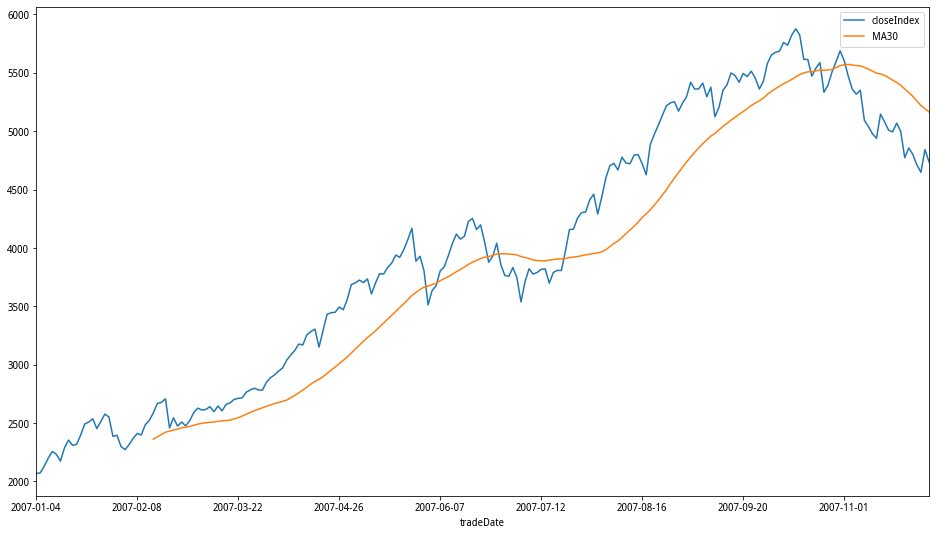

In [25]:
MA_df[['tradeDate','closeIndex','MA30']].set_index('tradeDate').loc[:'2007-12'].plot()

- 当收盘价高于均线时买入，低于均线时卖出

Case 1:
1. t日：收盘价高于MA30，假设可以以当日收盘价买入
2. t+k日：收盘价低于MA30，假设可以以当日收盘价卖出

Case 2:
1. t日：收盘价高于MA30，假设不能以当日收盘价买入。以次日开盘价买入
2. t+k日：收盘价低于MA30，假设不能以当日收盘价卖出。以次日开盘价卖出

In [26]:
MA_df['signal'] = np.nan
MA_df.loc[MA_df['closeIndex'] > MA_df['MA30'], 'signal'] = 1
MA_df.loc[MA_df['closeIndex'] < MA_df['MA30'], 'signal'] = 0

In [27]:
MA_df[~MA_df['signal'].isna()]

,indexID,secShortName,tradeDate,openIndex,highestIndex,lowestIndex,closeIndex,turnoverVol,turnoverValue,close_ret,open_ret,close_ret_demean,open_ret_demean,MA30,signal
29,000300.ZICN,沪深300,2007-02-14,2527.5600,2594.6600,2520.5300,2588.3500,6277727900,5.846227e+10,0.026052,0.011692,0.025742,0.011361,2362.236000,1.0
30,000300.ZICN,沪深300,2007-02-15,2607.6300,2669.1800,2607.6300,2668.6300,7163132900,6.741569e+10,0.031016,0.031679,0.030706,0.031348,2382.287333,1.0
31,000300.ZICN,沪深300,2007-02-16,2692.6700,2717.5700,2660.4900,2676.7400,7590878500,7.159758e+10,0.003039,0.032612,0.002729,0.032281,2402.416000,1.0
32,000300.ZICN,沪深300,2007-02-26,2679.2700,2710.3000,2641.1200,2707.6800,7453156000,7.098161e+10,0.011559,-0.004976,0.011249,-0.005307,2421.620000,1.0
33,000300.ZICN,沪深300,2007-02-27,2717.8100,2719.5200,2454.9200,2457.4900,10773680700,1.011028e+11,-0.092400,0.014385,-0.092710,0.014054,2430.200000,1.0
34,000300.ZICN,沪深300,2007-02-28,2413.4200,2554.2300,2413.3300,2544.5700,8282257100,7.714825e+10,0.035435,-0.111998,0.035125,-0.112329,2439.820000,1.0
35,000300.ZICN,沪深300,2007-03-01,2550.2600,2550.3300,2439.5000,2473.5400,8215965500,7.429958e+10,-0.027914,0.056700,-0.028224,0.056369,2447.883667,1.0
36,000300.ZICN,沪深300,2007-03-02,2468.6700,2523.8600,2455.8200,2508.7300,5794680500,5.422210e+10,0.014227,-0.031993,0.013917,-0.032324,2459.049667,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3932,000300.ZICN,沪深300,2023-03-08,4030.7387,4037.2870,4011.5231,4034.1077,11793649300,1.916597e+11,-0.003642,-0.017765,-0.003952,-0.018096,4115.980253,0.0


In [28]:
MA_df['position_close'] = MA_df['signal'] # 第一天收盘价生成signal后，立即对应于第一天收盘价形成的头寸
MA_df['position_open'] = MA_df['signal'].shift() # 第一天用收盘价生成signal。对应于第二天的开盘价形成的头寸

In [29]:
MA_df['position_close_ret'] = MA_df['position_close'].shift() * MA_df['close_ret']
MA_df['position_open_ret'] = MA_df['position_open'].shift() * MA_df['open_ret']
MA_df['position_close_ret_demean'] = MA_df['position_close'].shift() * MA_df['close_ret_demean']
MA_df['position_open_ret_demean'] = MA_df['position_open'].shift() * MA_df['open_ret_demean']

In [30]:
MA_df['MA30_close_cumret'] = (MA_df['position_close_ret']+1).cumprod()
MA_df['MA30_open_cumret'] = (MA_df['position_open_ret']+1).cumprod()

In [31]:
MA_df['signal'].unique()

array([nan,  1.,  0.])

In [32]:
MA_df[MA_df['signal']==0]

,indexID,secShortName,tradeDate,openIndex,highestIndex,lowestIndex,closeIndex,turnoverVol,turnoverValue,close_ret,...,MA30,signal,position_close,position_open,position_close_ret,position_open_ret,position_close_ret_demean,position_open_ret_demean,MA30_close_cumret,MA30_open_cumret
97,000300.ZICN,沪深300,2007-06-04,3804.9600,3822.4100,3503.9400,3511.4300,9053101900,1.312962e+11,-0.076899,...,3673.361667,0.0,0.0,1.0,-0.076899,-0.037474,-0.077209,-0.037805,1.356627,1.459164
98,000300.ZICN,沪深300,2007-06-05,3407.0000,3635.1500,3246.7300,3634.6300,11376803800,1.507649e+11,0.035085,...,3685.062667,0.0,0.0,0.0,0.000000,-0.104590,0.000000,-0.104921,1.356627,1.306550
99,000300.ZICN,沪深300,2007-06-06,3652.8900,3712.5300,3550.7400,3677.5800,9595151000,1.359385e+11,0.011817,...,3697.498667,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.356627,1.306550
112,000300.ZICN,沪深300,2007-06-25,4066.4500,4105.9900,3850.8400,3877.5900,7003104400,1.134327e+11,-0.042908,...,3925.166667,0.0,0.0,1.0,-0.042908,-0.032519,-0.043218,-0.032849,1.383489,1.392962
113,000300.ZICN,沪深300,2007-06-26,3804.4100,3929.3700,3752.9300,3928.2100,5888511400,8.786774e+10,0.013055,...,3935.952333,0.0,0.0,0.0,0.000000,-0.064439,0.000000,-0.064770,1.383489,1.303200
115,000300.ZICN,沪深300,2007-06-28,4038.3800,4067.8100,3857.8500,3858.5200,6685798000,9.837205e+10,-0.045034,...,3949.955667,0.0,0.0,1.0,-0.045034,0.000000,-0.045344,0.000000,1.321185,1.303200
116,000300.ZICN,沪深300,2007-06-29,3769.3300,3867.7500,3718.1600,3764.0800,5892087000,8.852759e+10,-0.024476,...,3949.537333,0.0,0.0,0.0,-0.000000,-0.066623,-0.000000,-0.066954,1.321185,1.216377
117,000300.ZICN,沪深300,2007-07-02,3746.1800,3801.9000,3644.1900,3757.6600,4974731000,7.199587e+10,-0.001706,...,3947.078000,0.0,0.0,0.0,-0.000000,-0.000000,-0.000000,-0.000000,1.321185,1.216377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3932,000300.ZICN,沪深300,2023-03-08,4030.7387,4037.2870,4011.5231,4034.1077,11793649300,1.916597e+11,-0.003642,...,4115.980253,0.0,0.0,0.0,-0.000000,-0.000000,-0.000000,-0.000000,4.095217,2.474525


In [33]:
MA_df.loc[96:99]

,indexID,secShortName,tradeDate,openIndex,highestIndex,lowestIndex,closeIndex,turnoverVol,turnoverValue,close_ret,...,MA30,signal,position_close,position_open,position_close_ret,position_open_ret,position_close_ret_demean,position_open_ret_demean,MA30_close_cumret,MA30_open_cumret
96,000300.ZICN,沪深300,2007-06-01,3953.10,4014.15,3780.03,3803.95,11993793900,1.939803e+11,-0.031569,...,3664.847333,1.0,1.0,1.0,-0.031569,0.032432,-0.031879,0.032101,1.469641,1.515974
97,000300.ZICN,沪深300,2007-06-04,3804.96,3822.41,3503.94,3511.43,9053101900,1.312962e+11,-0.076899,...,3673.361667,0.0,0.0,1.0,-0.076899,-0.037474,-0.077209,-0.037805,1.356627,1.459164
98,000300.ZICN,沪深300,2007-06-05,3407.00,3635.15,3246.73,3634.63,11376803800,1.507649e+11,0.035085,...,3685.062667,0.0,0.0,0.0,0.000000,-0.104590,0.000000,-0.104921,1.356627,1.306550
99,000300.ZICN,沪深300,2007-06-06,3652.89,3712.53,3550.74,3677.58,9595151000,1.359385e+11,0.011817,...,3697.498667,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.356627,1.306550


In [34]:
3511.43/3803.95 - 1

-0.07689901286820278

In [35]:
3407.00 / 3804.96 - 1

-0.10458979857869732

In [36]:
## Example
temp = MA_df.loc[99:113,['tradeDate','openIndex','closeIndex','close_ret','open_ret','signal',
                        'position_close','position_open','position_close_ret','position_open_ret',
                        'position_close_ret_demean','position_open_ret_demean']].copy()
temp['MA30_close_cumret'] = (temp['position_close_ret']+1).cumprod()
temp['MA30_open_cumret'] = (temp['position_open_ret']+1).cumprod()

display(temp)

# close 
print(3877.59 / 3802.30)

# open
print(3804.41 / 3814.19)

,tradeDate,openIndex,closeIndex,close_ret,open_ret,signal,position_close,position_open,position_close_ret,position_open_ret,position_close_ret_demean,position_open_ret_demean,MA30_close_cumret,MA30_open_cumret
99,2007-06-06,3652.89,3677.58,0.011817,0.072172,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
100,2007-06-07,3694.55,3802.30,0.033914,0.011405,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
101,2007-06-08,3814.19,3837.87,0.009355,0.032383,1.0,1.0,1.0,0.009355,0.000000,0.009045,0.000000,1.009355,1.000000
102,2007-06-11,3876.07,3931.86,0.024490,0.016224,1.0,1.0,1.0,0.024490,0.016224,0.024180,0.015893,1.034074,1.016224
103,2007-06-12,3953.96,4036.11,0.026514,0.020095,1.0,1.0,1.0,0.026514,0.020095,0.026204,0.019764,1.061492,1.036645
104,2007-06-13,4071.74,4118.27,0.020356,0.029788,1.0,1.0,1.0,0.020356,0.029788,0.020046,0.029457,1.083099,1.067524
105,2007-06-14,4103.52,4075.82,-0.010308,0.007805,1.0,1.0,1.0,-0.010308,0.007805,-0.010618,0.007474,1.071935,1.075856
106,2007-06-15,4043.11,4099.38,0.005780,-0.014722,1.0,1.0,1.0,0.005780,-0.014722,0.005470,-0.015052,1.078130,1.060018
107,2007-06-18,4178.76,4227.57,0.031271,0.033551,1.0,1.0,1.0,0.031271,0.033551,0.030961,0.033220,1.111845,1.095583
108,2007-06-19,4227.59,4253.00,0.006015,0.011685,1.0,1.0,1.0,0.006015,0.011685,0.005705,0.011355,1.118532,1.108385


1.0198011729742524
0.9974358907133625


In [37]:
MA30_ret_df = MA_df[['tradeDate','openIndex','closeIndex','open_ret','close_ret','MA30',
                        'signal','position_close','position_open','position_close_ret','position_open_ret',
                        'position_close_ret_demean','position_open_ret_demean',
                        'MA30_close_cumret','MA30_open_cumret']].copy()

In [38]:
MA30_ret_df.set_index('tradeDate',inplace=True)

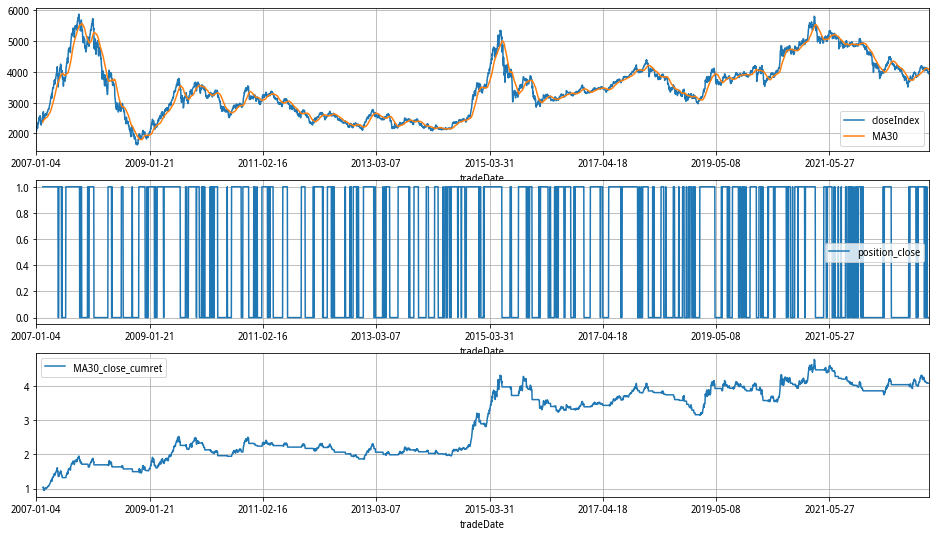

In [39]:
# Close price cumret
fig, axes = plt.subplots(3,1)
MA30_ret_df[['closeIndex','MA30']].plot(ax=axes[0],grid=True)
MA30_ret_df[['position_close']].plot(ax=axes[1],grid=True)
MA30_ret_df[['MA30_close_cumret']].plot(ax=axes[2],grid=True)

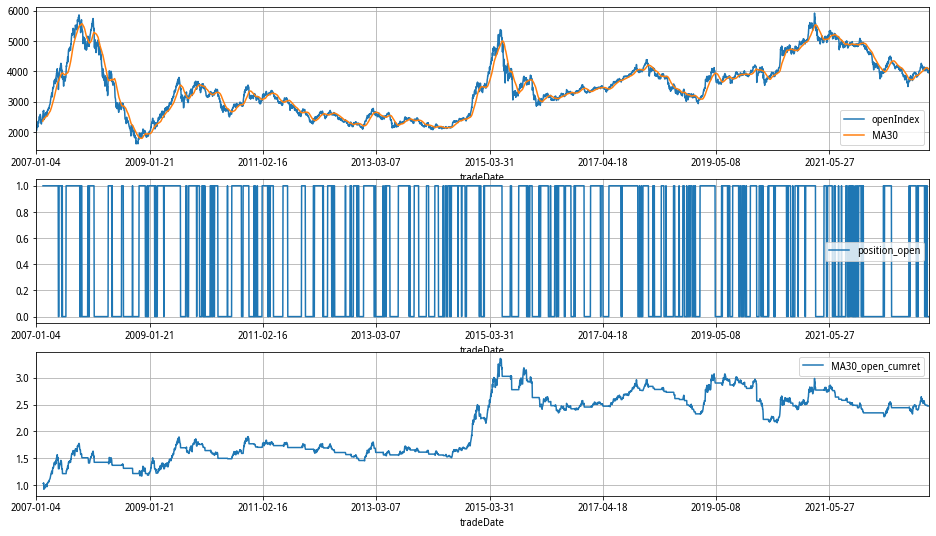

In [40]:
# open price cumret
fig, axes = plt.subplots(3,1)
MA30_ret_df[['openIndex','MA30']].plot(ax=axes[0],grid=True)
MA30_ret_df[['position_open']].plot(ax=axes[1], grid=True)
MA30_ret_df[['MA30_open_cumret']].plot(ax=axes[2], grid=True)

### MA20

In [41]:
hs300_df

,indexID,secShortName,tradeDate,openIndex,highestIndex,lowestIndex,closeIndex,turnoverVol,turnoverValue,close_ret,open_ret,close_ret_demean,open_ret_demean
0,000300.ZICN,沪深300,2007-01-04,2073.2500,2139.4900,2054.2400,2067.0900,10671970700,8.238107e+10,0.012758,NaN,0.012448,NaN
1,000300.ZICN,沪深300,2007-01-05,2051.1500,2083.4000,2030.7600,2072.8800,9274344700,6.802606e+10,0.002801,-0.010660,0.002491,-0.010990
2,000300.ZICN,沪深300,2007-01-08,2072.0000,2131.7400,2071.7200,2131.5600,8476790900,6.630394e+10,0.028308,0.010165,0.027998,0.009834
3,000300.ZICN,沪深300,2007-01-09,2137.4900,2201.3600,2128.0600,2200.0900,8157762900,6.545619e+10,0.032150,0.031607,0.031840,0.031276
4,000300.ZICN,沪深300,2007-01-10,2210.7600,2255.9700,2194.7700,2255.9700,8490497900,6.882262e+10,0.025399,0.034279,0.025089,0.033948
5,000300.ZICN,沪深300,2007-01-11,2257.0100,2289.9500,2224.3700,2231.6300,8627654800,6.873001e+10,-0.010789,0.020920,-0.011099,0.020590
6,000300.ZICN,沪深300,2007-01-12,2215.8600,2249.5400,2159.7700,2173.7500,7652572000,6.174283e+10,-0.025936,-0.018232,-0.026246,-0.018563
7,000300.ZICN,沪深300,2007-01-15,2170.9400,2287.6800,2170.9400,2287.3400,6640309700,5.704345e+10,0.052255,-0.020272,0.051945,-0.020603
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3932,000300.ZICN,沪深300,2023-03-08,4030.7387,4037.2870,4011.5231,4034.1077,11793649300,1.916597e+11,-0.003642,-0.017765,-0.003952,-0.018096


In [42]:
MA_df = hs300_df.copy()

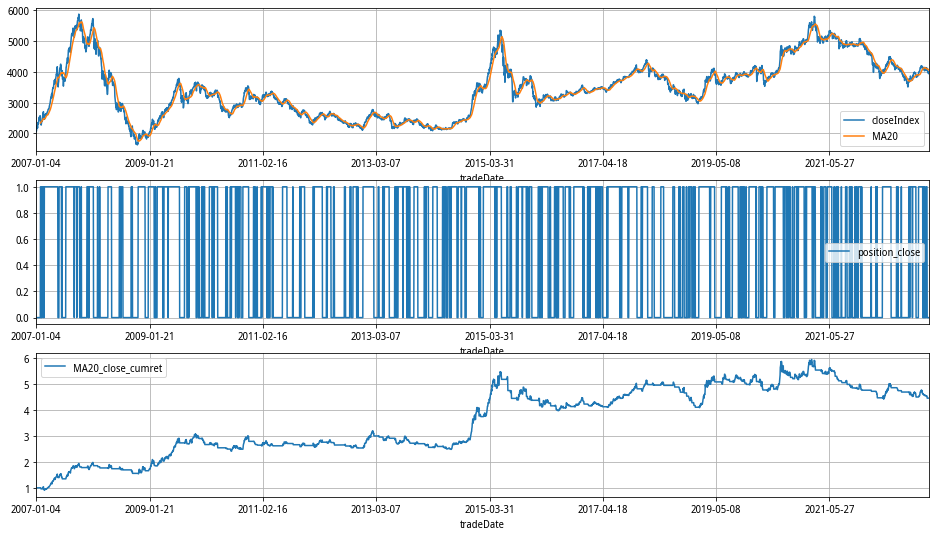

In [43]:
ma_length = 20

MA_df[f'MA{ma_length}'] = ta.SMA(MA_df['closeIndex'], ma_length)
MA_df['signal'] = 0
ndays = MA_df.shape[0]
MA_df.loc[MA_df['closeIndex'] > MA_df[f'MA{ma_length}'], 'signal'] = 1
MA_df['open_ret'] = MA_df['openIndex']/MA_df['openIndex'].shift()-1
MA_df['position_close'] = MA_df['signal']
MA_df['position_open'] = MA_df['signal'].shift()
MA_df.rename(columns={'CHGPct':'close_ret'},inplace=True)
MA_df['position_close'] = MA_df['signal']
MA_df['position_close_ret'] = MA_df['position_close'].shift() * MA_df['close_ret']
MA_df['position_open_ret'] = MA_df['position_open'].shift() * MA_df['open_ret']
MA_df['position_close_ret_demean'] = MA_df['position_close'].shift() * MA_df['close_ret_demean']
MA_df['position_open_ret_demean'] = MA_df['position_open'].shift() * MA_df['open_ret_demean']

MA_df[f'MA{ma_length}_close_cumret'] = (MA_df['position_close_ret']+1).cumprod()
MA_df[f'MA{ma_length}_open_cumret'] = (MA_df['position_open_ret']+1).cumprod()
MA_ret_df = MA_df[['tradeDate','openIndex','closeIndex','open_ret','close_ret',f'MA{ma_length}',
                        'signal','position_close','position_open','position_close_ret','position_open_ret',
                        'position_close_ret_demean','position_open_ret_demean',
                        f'MA{ma_length}_close_cumret',f'MA{ma_length}_open_cumret']].copy()
MA_ret_df.set_index('tradeDate',inplace=True)
# Close price cumret
fig, axes = plt.subplots(3,1)
MA_ret_df[['closeIndex',f'MA{ma_length}']].plot(ax=axes[0],grid=True)
MA_ret_df[['position_close']].plot(ax=axes[1],grid=True)
MA_ret_df[[f'MA{ma_length}_close_cumret']].plot(ax=axes[2],grid=True)

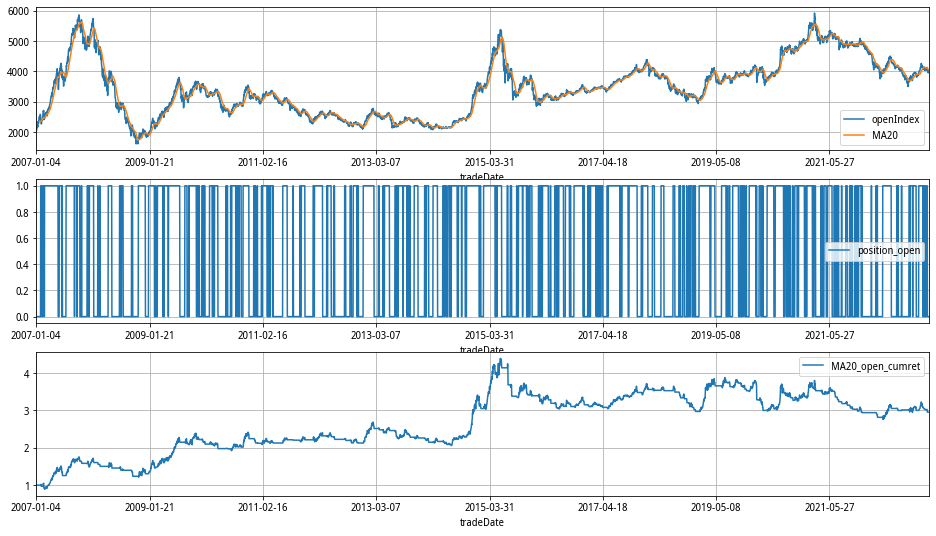

In [44]:
# open price cumret
fig, axes = plt.subplots(3,1)
MA_ret_df[['openIndex',f'MA{ma_length}']].plot(ax=axes[0],grid=True)
MA_ret_df[['position_open']].plot(ax=axes[1],grid=True)
MA_ret_df[[f'MA{ma_length}_open_cumret']].plot(ax=axes[2],grid=True)

## Exponential moving average

In [45]:
ta.EMA?

Docstring:
EMA(real[, timeperiod=?])

Exponential Moving Average (Overlap Studies)

Inputs:
    real: (any ndarray)
Parameters:
    timeperiod: 30
Outputs:
    real
Type:      function


\begin{aligned}
E M A_{\text {Today }}=&\left(\text { Value }_{\text {Today }} *\left(\frac{\text { Smoothing }}{1+\text { Days }}\right)\right) \\
&+E M A_{\text {Yesterday }} *\left(1-\left(\frac{\text { Smoothing }}{1+\text { Days }}\right)\right)
\end{aligned}

Smoothing = 2

### EMA20

In [46]:
ema_length = 20
EMA_df = hs300_df.copy()
EMA_df['EMA'] = ta.EMA(EMA_df['closeIndex'], ema_length)

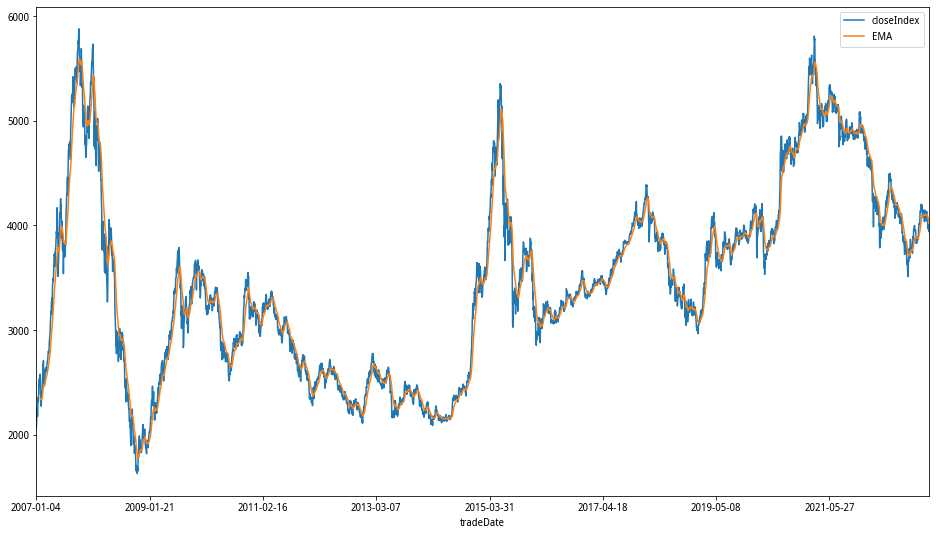

In [47]:
EMA_df[['tradeDate','closeIndex','EMA']].set_index('tradeDate').plot()

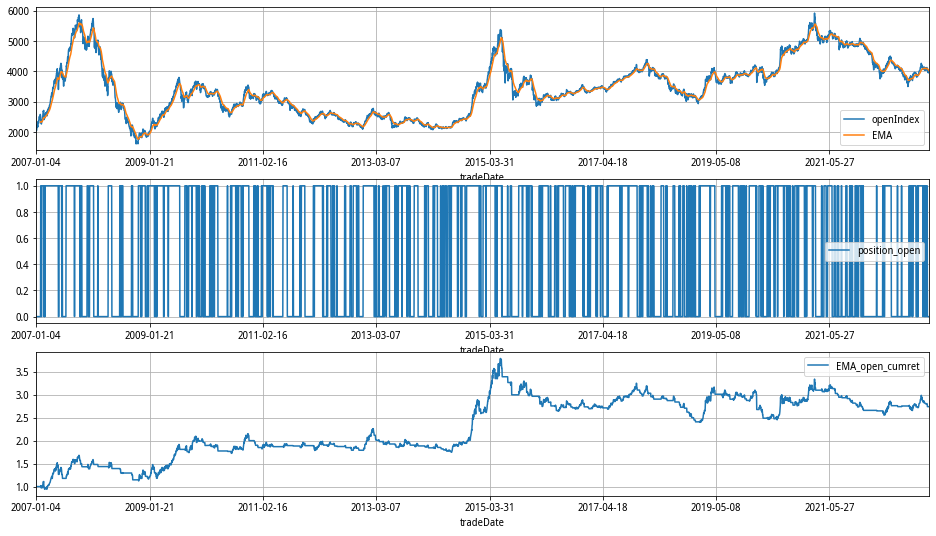

In [48]:
EMA_df['EMA'] = ta.EMA(EMA_df['closeIndex'], ema_length)
EMA_df['signal'] = 0
EMA_df.loc[EMA_df['closeIndex'] > EMA_df['EMA'], 'signal'] = 1
EMA_df['open_ret'] = EMA_df['openIndex']/EMA_df['openIndex'].shift()-1
EMA_df['position_close'] = EMA_df['signal']
EMA_df['position_open'] = EMA_df['signal'].shift()
EMA_df.rename(columns={'CHGPct':'close_ret'},inplace=True)
EMA_df['position_close_ret'] = EMA_df['position_close'].shift() * EMA_df['close_ret']
EMA_df['position_open_ret'] = EMA_df['position_open'].shift() * EMA_df['open_ret']
EMA_df['position_close_ret_demean'] = EMA_df['position_close'].shift() * EMA_df['close_ret_demean']
EMA_df['position_open_ret_demean'] = EMA_df['position_open'].shift() * EMA_df['open_ret_demean']
EMA_df['EMA_close_cumret'] = (EMA_df['position_close_ret']+1).cumprod()
EMA_df['EMA_open_cumret'] = (EMA_df['position_open_ret']+1).cumprod()
EMA_ret_df = EMA_df[['tradeDate','openIndex','closeIndex','open_ret','close_ret','EMA',
                        'signal','position_close','position_open','position_close_ret','position_open_ret',
                       'position_close_ret_demean','position_open_ret_demean',
                        'EMA_close_cumret','EMA_open_cumret']].copy()
EMA_ret_df.set_index('tradeDate',inplace=True)
# open price cumret
fig, axes = plt.subplots(3,1)
EMA_ret_df[['openIndex','EMA']].plot(ax=axes[0], grid=True)
EMA_ret_df[['position_open']].plot(ax=axes[1], grid=True)
EMA_ret_df[['EMA_open_cumret']].plot(ax=axes[2], grid=True)

In [49]:
EMA_ret_df

,openIndex,closeIndex,open_ret,close_ret,EMA,signal,position_close,position_open,position_close_ret,position_open_ret,position_close_ret_demean,position_open_ret_demean,EMA_close_cumret,EMA_open_cumret
tradeDate,,,,,,,,,,,,,,
2007-01-04,2073.2500,2067.0900,NaN,0.012758,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-05,2051.1500,2072.8800,-0.010660,0.002801,NaN,0,0,0.0,0.0,NaN,0.0,NaN,1.000000,NaN
2007-01-08,2072.0000,2131.5600,0.010165,0.028308,NaN,0,0,0.0,0.0,0.000000,0.0,0.000000,1.000000,1.000000
2007-01-09,2137.4900,2200.0900,0.031607,0.032150,NaN,0,0,0.0,0.0,0.000000,0.0,0.000000,1.000000,1.000000
2007-01-10,2210.7600,2255.9700,0.034279,0.025399,NaN,0,0,0.0,0.0,0.000000,0.0,0.000000,1.000000,1.000000
2007-01-11,2257.0100,2231.6300,0.020920,-0.010789,NaN,0,0,0.0,-0.0,0.000000,-0.0,0.000000,1.000000,1.000000
2007-01-12,2215.8600,2173.7500,-0.018232,-0.025936,NaN,0,0,0.0,-0.0,-0.000000,-0.0,-0.000000,1.000000,1.000000
2007-01-15,2170.9400,2287.3400,-0.020272,0.052255,NaN,0,0,0.0,0.0,-0.000000,0.0,-0.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


# Statistical Inferences

## Cross-sectional test

In [50]:
def rule_return(df, demean=True, open_ret=True):
    """
    df should contain these columns:
        signal: the signal generated by the rule
        close_ret: return calculated by close price
        open_ret: return calculated by open price
    close_ret_demean is demeaned return of close_ret, i.e. close_ret - close_ret.mean.
    open_ret_demean is similarly defined. The use of demeaned return series is to adjust the
    bias created by bullish or bearish markets.
    """
    df['close_ret_demean'] = df['close_ret'] - df['close_ret'].mean()
    df['open_ret_demean'] = df['open_ret'] - df['open_ret'].mean()
    df['position_close'] = df['signal']
    df['position_open'] = df['signal'].shift()
    df['position_close_ret'] = df['position_close'].shift() * df['close_ret']
    df['position_open_ret'] = df['position_open'].shift() * df['open_ret']
    df['position_close_ret_demean'] = df['position_close'].shift() * df['close_ret_demean']
    df['position_open_ret_demean'] = df['position_open'].shift() * df['open_ret_demean']
    df['close_cumret'] = (df['position_close_ret']+1).cumprod()
    df['open_cumret'] = (df['position_open_ret']+1).cumprod()
    if open_ret:
        if demean:
            return pd.DataFrame({'tradeDate':df['tradeDate'].values,
                                 'position_open_ret_demean':df['position_open_ret_demean'].values, 
                                 'open_cumret':df['open_cumret'].values})
        else:
            return pd.DataFrame({'tradeDate':df['tradeDate'].values,
                                 'position_open_ret':df['position_open_ret'].values, 
                                 'open_cumret':df['open_cumret'].values})
    else:
        if demean:
            return pd.DataFrame({'tradeDate':df['tradeDate'].values,
                                 'position_close_ret_demean':df['position_close_ret_demean'].values, 
                                 'close_cumret':df['close_cumret'].values})
        else:
            return pd.DataFrame({'tradeDate':df['tradeDate'].values,
                                 'position_close_ret':df['position_close_ret'].values, 
                                 'close_cumret':df['close_cumret'].values})

In [51]:
ema_length = 20

In [52]:
stk_df

,secID,tradeDate,preClosePrice,closePrice,openPrice,highestPrice,lowestPrice,negMarketValue,turnoverValue,turnoverRate
109,000001.XSHE,2007-06-20,824.193,987.007,1044.285,1053.778,970.235,4.835036e+10,4.182345e+09,0.0840
110,000001.XSHE,2007-06-21,987.007,1085.740,1026.564,1085.740,988.906,5.318694e+10,2.285485e+09,0.0440
111,000001.XSHE,2007-06-22,1085.740,1120.233,1126.562,1132.891,1069.601,5.487665e+10,2.761567e+09,0.0510
112,000001.XSHE,2007-06-25,1120.233,1113.904,1139.536,1157.574,1087.005,5.456661e+10,2.324186e+09,0.0426
113,000001.XSHE,2007-06-26,1113.904,1113.904,0.000,0.000,0.000,5.456661e+10,0.000000e+00,0.0000
114,000001.XSHE,2007-06-27,1113.904,1019.602,1002.513,1069.284,1002.513,4.994705e+10,2.446556e+09,0.0489
115,000001.XSHE,2007-06-28,1019.602,953.780,996.817,1024.348,950.299,4.672266e+10,1.617434e+09,0.0336
116,000001.XSHE,2007-06-29,953.780,870.870,943.021,948.717,861.377,4.266117e+10,1.410758e+09,0.0316
...,...,...,...,...,...,...,...,...,...,...
11245239,689009.XSHG,2023-03-08,33.370,34.080,33.400,34.200,33.400,1.743874e+10,1.229896e+08,0.0071


In [53]:
stk_df['EMA'] = stk_df.groupby('secID')['closePrice'].apply(ta.EMA, 20)

In [54]:
stk_df.drop(stk_df.loc[stk_df['openPrice']==0].index, inplace=True) # drop 停牌但有收盘价的数据

In [55]:
stk_df.loc[stk_df['openPrice']==0]

,secID,tradeDate,preClosePrice,closePrice,openPrice,highestPrice,lowestPrice,negMarketValue,turnoverValue,turnoverRate,EMA


In [56]:
stk_df['open_ret'] = stk_df.groupby('secID')['openPrice'].apply(lambda x: x / x.shift() - 1)

In [57]:
stk_df['close_ret'] = stk_df['closePrice']/stk_df['preClosePrice'] - 1


In [58]:
stk_df['signal'] = 0
stk_df.loc[stk_df['closePrice'] > stk_df['EMA'], 'signal'] = 1

In [59]:
stk_df

,secID,tradeDate,preClosePrice,closePrice,openPrice,highestPrice,lowestPrice,negMarketValue,turnoverValue,turnoverRate,EMA,open_ret,close_ret,signal
109,000001.XSHE,2007-06-20,824.193,987.007,1044.285,1053.778,970.235,4.835036e+10,4.182345e+09,0.0840,NaN,NaN,0.197544,0
110,000001.XSHE,2007-06-21,987.007,1085.740,1026.564,1085.740,988.906,5.318694e+10,2.285485e+09,0.0440,NaN,-0.016970,0.100033,0
111,000001.XSHE,2007-06-22,1085.740,1120.233,1126.562,1132.891,1069.601,5.487665e+10,2.761567e+09,0.0510,NaN,0.097410,0.031769,0
112,000001.XSHE,2007-06-25,1120.233,1113.904,1139.536,1157.574,1087.005,5.456661e+10,2.324186e+09,0.0426,NaN,0.011516,-0.005650,0
114,000001.XSHE,2007-06-27,1113.904,1019.602,1002.513,1069.284,1002.513,4.994705e+10,2.446556e+09,0.0489,NaN,-0.120245,-0.084659,0
115,000001.XSHE,2007-06-28,1019.602,953.780,996.817,1024.348,950.299,4.672266e+10,1.617434e+09,0.0336,NaN,-0.005682,-0.064557,0
116,000001.XSHE,2007-06-29,953.780,870.870,943.021,948.717,861.377,4.266117e+10,1.410758e+09,0.0316,NaN,-0.053968,-0.086928,0
117,000001.XSHE,2007-07-02,870.870,867.073,848.402,881.629,840.807,4.247515e+10,8.756147e+08,0.0209,NaN,-0.100336,-0.004360,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11245239,689009.XSHG,2023-03-08,33.370,34.080,33.400,34.200,33.400,1.743874e+10,1.229896e+08,0.0071,33.677879,-0.017647,0.021277,1


In [60]:
%%time
rule_ret_df = stk_df.groupby('secID').apply(rule_return)

CPU times: user 43.3 s, sys: 1.15 s, total: 44.5 s
Wall time: 44.5 s


In [61]:
rule_ret_df.reset_index(inplace=True)

In [62]:
rule_ret_df.drop('level_1',axis=1,inplace=True)

In [63]:
rule_ret_df

,secID,tradeDate,position_open_ret_demean,open_cumret
0,000001.XSHE,2007-06-20,NaN,NaN
1,000001.XSHE,2007-06-21,NaN,NaN
2,000001.XSHE,2007-06-22,0.000000,1.000000
3,000001.XSHE,2007-06-25,0.000000,1.000000
4,000001.XSHE,2007-06-27,-0.000000,1.000000
5,000001.XSHE,2007-06-28,-0.000000,1.000000
6,000001.XSHE,2007-06-29,-0.000000,1.000000
7,000001.XSHE,2007-07-02,-0.000000,1.000000
...,...,...,...,...
10347861,689009.XSHG,2023-03-08,-0.018459,0.947095


### Cross-sectional test of cumulative return

In [64]:
rule_cumret_by_crs = rule_ret_df.groupby('secID')['open_cumret'].last()

In [65]:
rule_cumret_by_crs.describe()

count    5071.000000
mean        2.122027
std         3.338064
min         0.063227
25%         0.690821
50%         1.061444
75%         2.125068
max        44.108781
Name: open_cumret, dtype: float64

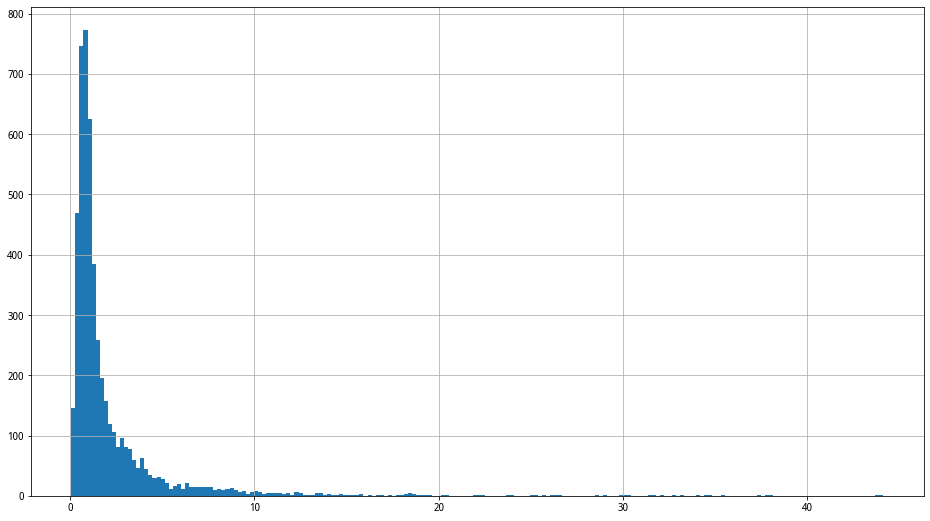

In [66]:
rule_cumret_by_crs.hist(bins=200)

In [67]:
rule_cumret_by_crs.dropna(inplace=True)
y = rule_cumret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y-const, const).fit().get_robustcov_results(cov_type='HC0')
mean_values = reg.params[0]
t_values = reg.tvalues[0]
pd.DataFrame([mean_values,t_values],index=['ret_mean','t_values'],columns=['rule_cumret'])

,rule_cumret
ret_mean,1.122027
t_values,23.938577


In [68]:
rule_cumret_by_crs.dropna(inplace=True)
y = rule_cumret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y, const).fit()
print(reg.t_test('const = 1'))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             2.1220      0.047     23.936      0.000       2.030       2.214


平均年化收益：

In [69]:
# 1.12/(2022-2007+1)
2.12**(1/(2022-2007+1)) - 1

0.048083759133757065

### Cross-sectional test of mean daily return

In [70]:
# time-series mean of daily return
rule_tsmean_ret_by_crs = rule_ret_df.groupby('secID')['position_open_ret_demean'].mean()
rule_tsmean_ret_by_crs

secID
000001.XSHE    0.000112
000002.XSHE   -0.000018
000004.XSHE    0.000126
000005.XSHE    0.000357
000006.XSHE    0.000275
000007.XSHE    0.000151
000008.XSHE    0.000546
000009.XSHE    0.000282
                 ...   
688789.XSHG   -0.001912
688793.XSHG   -0.001870
688798.XSHG    0.000064
688799.XSHG    0.000012
688800.XSHG   -0.000639
688819.XSHG    0.000676
688981.XSHG    0.000151
689009.XSHG   -0.000118
Name: position_open_ret_demean, Length: 5073, dtype: float64

In [71]:
temp = stk_df[stk_df['secID']==np.random.choice(stk_df['secID'].unique(),1)[0]].copy()
temp['signal'] = 0
temp.loc[temp['closePrice'] > temp['EMA'], 'signal'] = 1
display(temp)
rule_return(temp)['position_open_ret_demean'].mean()

,secID,tradeDate,preClosePrice,closePrice,openPrice,highestPrice,lowestPrice,negMarketValue,turnoverValue,turnoverRate,EMA,open_ret,close_ret,signal
2691650,002218.XSHE,2008-02-28,10.790,51.620,54.000,57.000,48.800,1.651840e+09,1.379502e+09,0.8379,NaN,NaN,3.784059,0
2691651,002218.XSHE,2008-02-29,51.620,53.000,48.480,54.450,47.900,1.696000e+09,7.323495e+08,0.4412,NaN,-0.102222,0.026734,0
2691652,002218.XSHE,2008-03-03,53.000,55.000,53.710,57.600,53.500,1.760000e+09,5.391698e+08,0.3035,NaN,0.107880,0.037736,0
2691653,002218.XSHE,2008-03-04,55.000,53.620,55.490,56.700,53.000,1.715840e+09,2.923269e+08,0.1679,NaN,0.033141,-0.025091,0
2691654,002218.XSHE,2008-03-05,53.620,50.020,53.300,53.970,49.800,1.600640e+09,3.175247e+08,0.1937,NaN,-0.039467,-0.067139,0
2691655,002218.XSHE,2008-03-06,50.020,47.700,49.700,50.700,47.500,1.526400e+09,2.608205e+08,0.1668,NaN,-0.067542,-0.046381,0
2691656,002218.XSHE,2008-03-07,47.700,45.710,46.990,47.660,45.680,1.462720e+09,1.588991e+08,0.1073,NaN,-0.054527,-0.041719,0
2691657,002218.XSHE,2008-03-10,45.710,46.290,45.060,47.250,44.450,1.481280e+09,1.185497e+08,0.0804,NaN,-0.041073,0.012689,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695304,002218.XSHE,2023-03-08,32.024,32.081,31.798,32.476,31.742,7.878716e+09,8.390550e+07,0.0107,32.792957,-0.030992,0.001780,0


-0.00011982715955345444

In [72]:
rule_tsmean_ret_by_crs['002976.XSHE']

-0.0010017766799079067

In [73]:
rule_tsmean_ret_by_crs.dropna(inplace=True)
y = rule_tsmean_ret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HC0')
mean_values = reg.params[0]
t_values = reg.tvalues[0]

In [74]:
pd.DataFrame([mean_values,t_values],index=['ret_mean','t_values'],columns=['rule_daily_ret'])

,rule_daily_ret
ret_mean,-0.000100
t_values,-9.956723


## Time series test. Bootstrapping: White's Reality Check

- 原始index return去掉均值的目的：过滤掉牛市或者熊市时，随机策略的正或负的收益的偏误
- position return 去掉均值的目的：bootstrap 的原假设是：策略期望收益是0。以此生成抽样分布。

In [75]:
EMA_ret_df

,openIndex,closeIndex,open_ret,close_ret,EMA,signal,position_close,position_open,position_close_ret,position_open_ret,position_close_ret_demean,position_open_ret_demean,EMA_close_cumret,EMA_open_cumret
tradeDate,,,,,,,,,,,,,,
2007-01-04,2073.2500,2067.0900,NaN,0.012758,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-05,2051.1500,2072.8800,-0.010660,0.002801,NaN,0,0,0.0,0.0,NaN,0.0,NaN,1.000000,NaN
2007-01-08,2072.0000,2131.5600,0.010165,0.028308,NaN,0,0,0.0,0.0,0.000000,0.0,0.000000,1.000000,1.000000
2007-01-09,2137.4900,2200.0900,0.031607,0.032150,NaN,0,0,0.0,0.0,0.000000,0.0,0.000000,1.000000,1.000000
2007-01-10,2210.7600,2255.9700,0.034279,0.025399,NaN,0,0,0.0,0.0,0.000000,0.0,0.000000,1.000000,1.000000
2007-01-11,2257.0100,2231.6300,0.020920,-0.010789,NaN,0,0,0.0,-0.0,0.000000,-0.0,0.000000,1.000000,1.000000
2007-01-12,2215.8600,2173.7500,-0.018232,-0.025936,NaN,0,0,0.0,-0.0,-0.000000,-0.0,-0.000000,1.000000,1.000000
2007-01-15,2170.9400,2287.3400,-0.020272,0.052255,NaN,0,0,0.0,0.0,-0.000000,0.0,-0.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [76]:
rule_ret_series = EMA_ret_df['position_open_ret_demean'].dropna() # position_open_ret_demean: (raw return demeaned)*position
rule_ret_series_for_bootstrap = rule_ret_series - rule_ret_series.mean() # demean here: H0: the average of the rule's return is zero
n_sample = rule_ret_series.shape[0]
n_boostrap = 1000

In [77]:
n_sample

3938

In [78]:
rule_ret_series.mean()

0.00015032213667165277

In [79]:
rule_ret_mean_distr = []
for i in range(n_boostrap):
    rule_ret_mean_distr.append(np.random.choice(rule_ret_series_for_bootstrap, n_sample).mean())

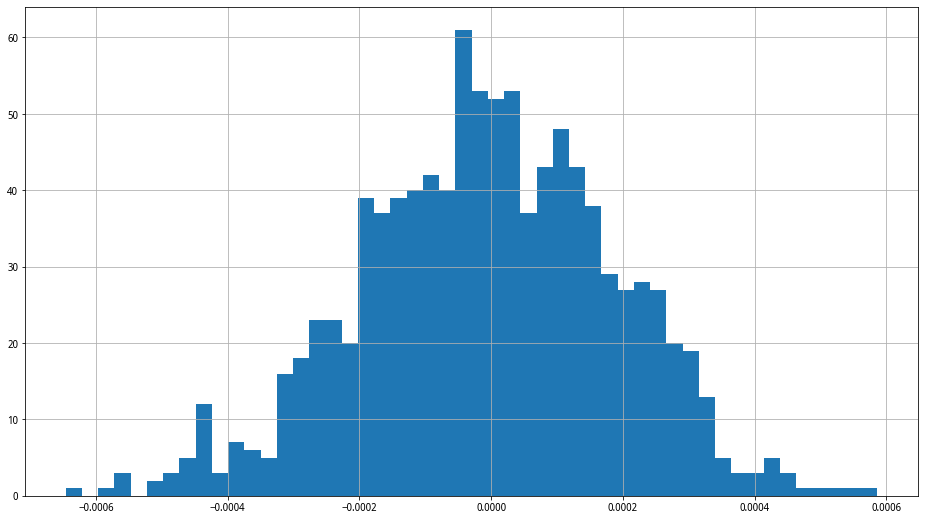

In [80]:
rule_ret_mean_distr = pd.Series(rule_ret_mean_distr)
rule_ret_mean_distr.hist(bins=50)

In [81]:
(rule_ret_mean_distr > rule_ret_series.mean()).sum()

211

In [82]:
(rule_ret_mean_distr > rule_ret_series.mean()).sum() / n_boostrap

0.211

In [83]:
np.mean(rule_ret_series)

0.00015032213667165277

In [84]:
def white_reality_test(rule_ret, n_boostrap=1000):
    n_sample = len(rule_ret)
    if n_sample < 100:
        return None
    else:
        mean_rule_ret = np.mean(rule_ret)
        rule_ret_for_bootstrap = rule_ret - mean_rule_ret
        rule_ret_mean_distr = []
        for i in range(n_boostrap):
            rule_ret_mean_distr.append(np.random.choice(rule_ret_for_bootstrap, n_sample).mean())
        rule_ret_mean_distr = pd.Series(rule_ret_mean_distr)
        pvalue = (rule_ret_mean_distr > mean_rule_ret).sum() / n_boostrap
        return pvalue

In [85]:
# The p value of the rule's return series
white_reality_test(rule_ret_series)

0.195

#### Test another stock

In [86]:
one_stk_id = np.random.choice(rule_ret_df['secID'].unique(),1)[0]

In [87]:
rule_ret_series = rule_ret_df.loc[rule_ret_df['secID'] == one_stk_id,'position_open_ret_demean']

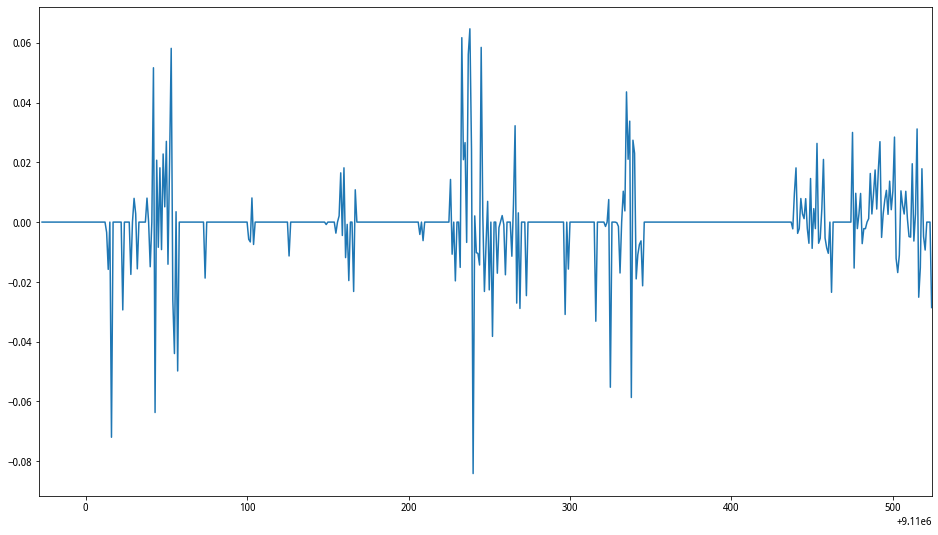

In [88]:
rule_ret_series.plot()

In [89]:
rule_ret_series.dropna(inplace=True)

In [90]:
white_reality_test(rule_ret_series)

0.667

#### Test 300 stocks

In [91]:
stk_id_300 = np.random.choice(rule_ret_df['secID'].unique(),300,replace=False)

In [92]:
temp = rule_ret_df.loc[rule_ret_df['secID'].isin(stk_id_300)].copy()

In [93]:
temp.dropna(inplace=True)

In [94]:
temp

,secID,tradeDate,position_open_ret_demean,open_cumret
3746,000002.XSHE,2007-01-08,-0.000000,1.000000
3747,000002.XSHE,2007-01-09,0.000000,1.000000
3748,000002.XSHE,2007-01-10,0.000000,1.000000
3749,000002.XSHE,2007-01-11,0.000000,1.000000
3750,000002.XSHE,2007-01-12,-0.000000,1.000000
3751,000002.XSHE,2007-01-15,-0.000000,1.000000
3752,000002.XSHE,2007-01-16,0.000000,1.000000
3753,000002.XSHE,2007-01-17,0.000000,1.000000
...,...,...,...,...
10338102,688722.XSHG,2023-03-08,-0.030503,0.906837


In [95]:
%%time
stk_white_p = temp.groupby('secID')['position_open_ret_demean'].apply(white_reality_test)

CPU times: user 33.4 s, sys: 0 ns, total: 33.4 s
Wall time: 33.4 s


In [96]:
stk_white_p

secID
000002.XSHE    0.522
000026.XSHE    0.211
000038.XSHE    0.427
000040.XSHE    0.102
000089.XSHE    0.503
000547.XSHE    0.136
000557.XSHE    0.626
000562.XSHE    0.136
               ...  
688475.XSHG      NaN
688511.XSHG    0.841
688513.XSHG    0.727
688521.XSHG    0.170
688599.XSHG    0.536
688661.XSHG    0.628
688676.XSHG    0.319
688722.XSHG    0.694
Name: position_open_ret_demean, Length: 300, dtype: float64

In [97]:
stk_white_p.describe()

count    293.000000
mean       0.501430
std        0.255257
min        0.025000
25%        0.291000
50%        0.498000
75%        0.694000
max        0.998000
Name: position_open_ret_demean, dtype: float64

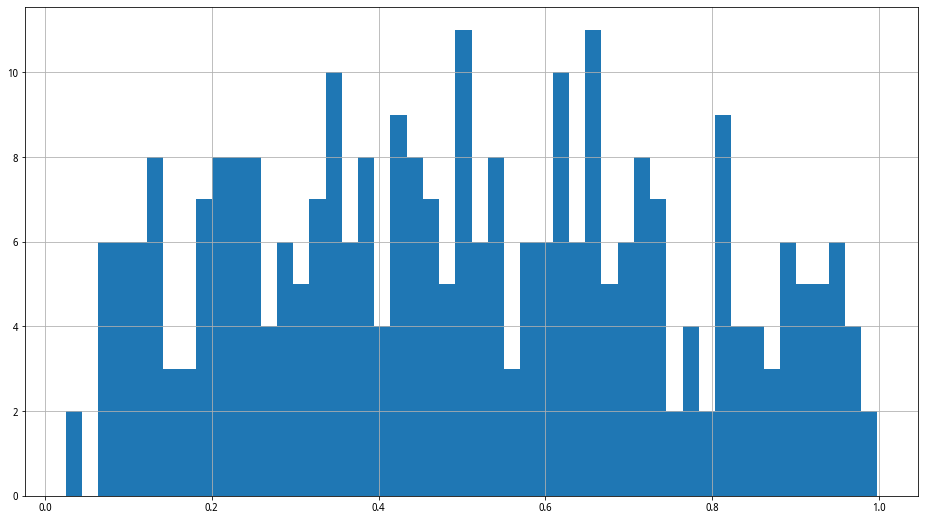

In [98]:
stk_white_p.hist(bins=50)

In [99]:
stk_white_p.loc[stk_white_p < 0.10]

secID
000709.XSHE    0.025
002019.XSHE    0.088
002031.XSHE    0.098
300268.XSHE    0.076
600077.XSHG    0.033
600291.XSHG    0.077
600432.XSHG    0.096
600698.XSHG    0.067
601718.XSHG    0.084
688119.XSHG    0.071
688320.XSHG    0.066
688338.XSHG    0.073
Name: position_open_ret_demean, dtype: float64

In [100]:
good_EMA_stks = stk_white_p.loc[stk_white_p < 0.10].index

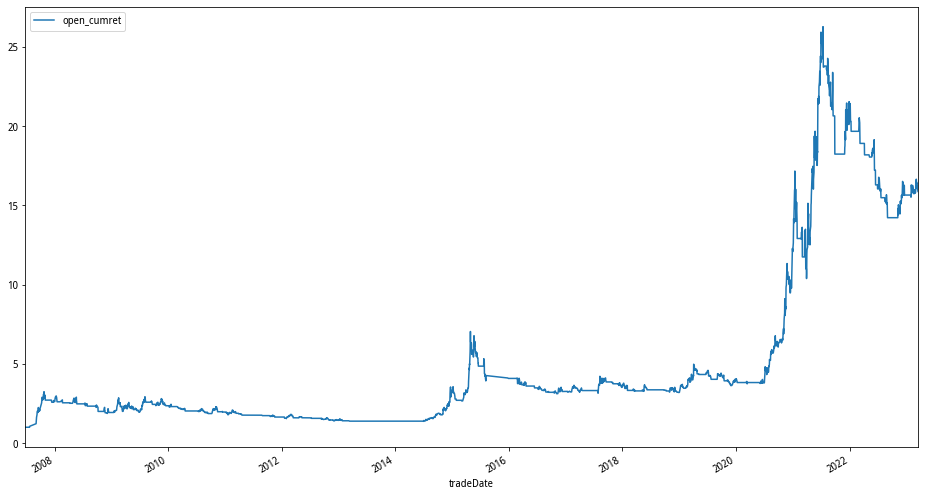

In [101]:
rule_ret_df.loc[rule_ret_df['secID']=='601919.XSHG',['tradeDate','open_cumret']].set_index('tradeDate').plot()

In [102]:
rule_ret_df.loc[rule_ret_df['secID'].isin(good_EMA_stks[0:5])].set_index('tradeDate',inplace=True)

In [103]:
temp2 = rule_ret_df.loc[rule_ret_df['secID'].isin(good_EMA_stks)].copy()

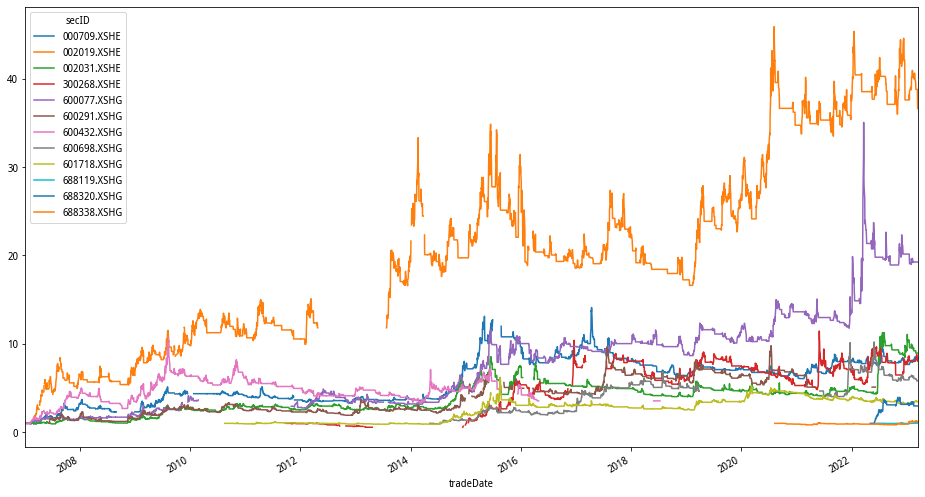

In [104]:
temp2.pivot(index='tradeDate',columns='secID',values='open_cumret').plot()

# MACD

Moving Average Convergence Divergence (MACD)

$$MACD = EMA_{\text{fast period}} - EMA_{\text{slow period}}$$

$$E M A_t(\text{Value})= \left(\text { Value }_t *\left(\frac{\text { Smoothing }}{1+\text { Days }}\right)\right) + E M A_{t-1} *\left(1-\left(\frac{\text { Smoothing }}{1+\text { Days }}\right)\right)$$

$Smoothing = 2$, $\text{fast period} = 12$, $\text{slow period} = 26$. 第一个$EMA$用简单平均。比如，计算$EMA_{\text{12 period}}$，那么就等有12个观测值之后，取简单平均得到$EMA_1$，然后$EMA_2$用上述公式计算。

按照级数展开可发现，越靠近当前的价格，权重越大。Smoothing越大，越靠近当前价格的权重越大。

得到 MACD 以后，再计算 MACD 的 Signal，

$$Signal = EMA_{\text{9 period}}(MACD) $$

判断标准：当 MACD 上穿 Signal 时，处于上升趋势。当 MACD 下穿 Signal 时，处于下降趋势。

In [105]:
MACD_df = hs300_df.copy()

In [106]:
fastperiod = 12  
slowperiod = 26  
signalperiod = 9 

In [107]:
MACD_df

,indexID,secShortName,tradeDate,openIndex,highestIndex,lowestIndex,closeIndex,turnoverVol,turnoverValue,close_ret,open_ret,close_ret_demean,open_ret_demean
0,000300.ZICN,沪深300,2007-01-04,2073.2500,2139.4900,2054.2400,2067.0900,10671970700,8.238107e+10,0.012758,NaN,0.012448,NaN
1,000300.ZICN,沪深300,2007-01-05,2051.1500,2083.4000,2030.7600,2072.8800,9274344700,6.802606e+10,0.002801,-0.010660,0.002491,-0.010990
2,000300.ZICN,沪深300,2007-01-08,2072.0000,2131.7400,2071.7200,2131.5600,8476790900,6.630394e+10,0.028308,0.010165,0.027998,0.009834
3,000300.ZICN,沪深300,2007-01-09,2137.4900,2201.3600,2128.0600,2200.0900,8157762900,6.545619e+10,0.032150,0.031607,0.031840,0.031276
4,000300.ZICN,沪深300,2007-01-10,2210.7600,2255.9700,2194.7700,2255.9700,8490497900,6.882262e+10,0.025399,0.034279,0.025089,0.033948
5,000300.ZICN,沪深300,2007-01-11,2257.0100,2289.9500,2224.3700,2231.6300,8627654800,6.873001e+10,-0.010789,0.020920,-0.011099,0.020590
6,000300.ZICN,沪深300,2007-01-12,2215.8600,2249.5400,2159.7700,2173.7500,7652572000,6.174283e+10,-0.025936,-0.018232,-0.026246,-0.018563
7,000300.ZICN,沪深300,2007-01-15,2170.9400,2287.6800,2170.9400,2287.3400,6640309700,5.704345e+10,0.052255,-0.020272,0.051945,-0.020603
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3932,000300.ZICN,沪深300,2023-03-08,4030.7387,4037.2870,4011.5231,4034.1077,11793649300,1.916597e+11,-0.003642,-0.017765,-0.003952,-0.018096


In [108]:
MACD_df['MACD'], MACD_df['MACD_signal'], _ = ta.MACD(MACD_df['closeIndex'], fastperiod=fastperiod, slowperiod=slowperiod, signalperiod=signalperiod)

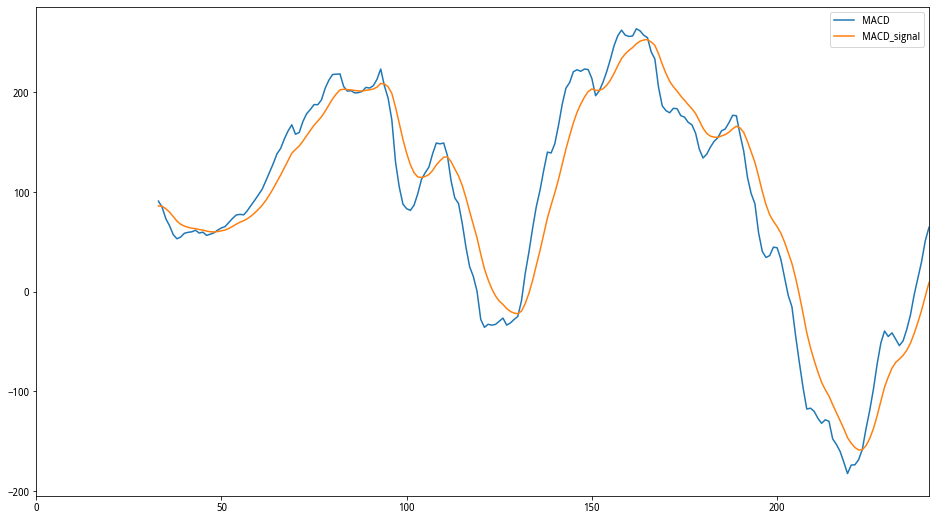

In [109]:
MACD_df.loc[MACD_df['tradeDate']<='2007-12-31',['MACD','MACD_signal']].plot()

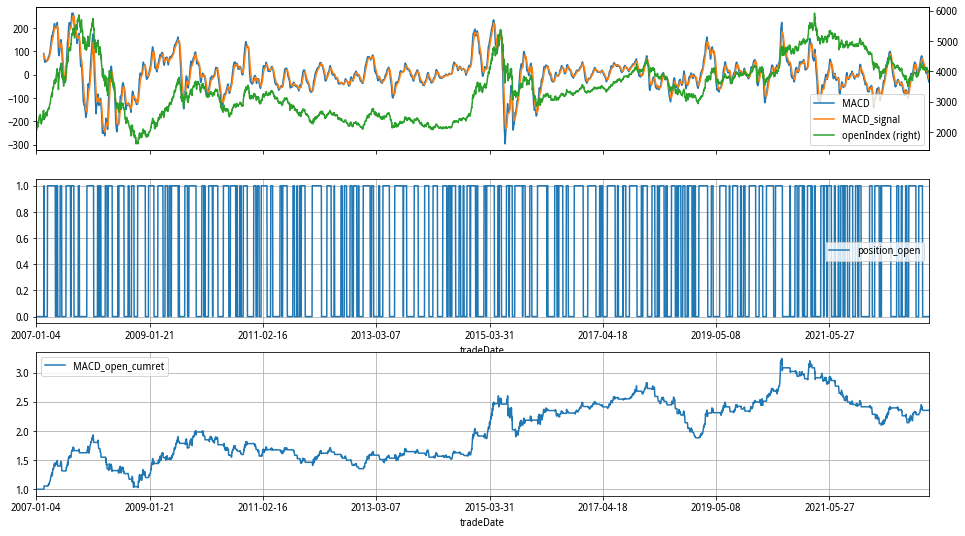

In [110]:
MACD_df['signal'] = 0
MACD_df.loc[MACD_df['MACD'] > MACD_df['MACD_signal'], 'signal'] = 1
MACD_df['open_ret'] = MACD_df['openIndex']/MACD_df['openIndex'].shift()-1
MACD_df['position_close'] = MACD_df['signal']
MACD_df['position_open'] = MACD_df['signal'].shift()
MACD_df.rename(columns={'CHGPct':'close_ret'},inplace=True)
MACD_df['position_close_ret'] = MACD_df['position_close'].shift() * MACD_df['close_ret']
MACD_df['position_open_ret'] = MACD_df['position_open'].shift() * MACD_df['open_ret']
MACD_df['position_close_ret_demean'] = MACD_df['position_close'].shift() * MACD_df['close_ret_demean']
MACD_df['position_open_ret_demean'] = MACD_df['position_open'].shift() * MACD_df['open_ret_demean']
MACD_df['MACD_close_cumret'] = (MACD_df['position_close_ret']+1).cumprod()
MACD_df['MACD_open_cumret'] = (MACD_df['position_open_ret']+1).cumprod()
MACD_ret_df = MACD_df[['tradeDate','openIndex','closeIndex','open_ret','close_ret','MACD','MACD_signal',
                        'signal','position_close','position_open','position_close_ret','position_open_ret',
                       'position_close_ret_demean','position_open_ret_demean',
                        'MACD_close_cumret','MACD_open_cumret']].copy()
MACD_ret_df.set_index('tradeDate',inplace=True)
# open price cumret
fig, axes = plt.subplots(3,1)
MACD_ret_df[['MACD','MACD_signal']].plot(ax=axes[0], grid=True)
MACD_ret_df[['openIndex']].plot(secondary_y=True,ax=axes[0])
MACD_ret_df[['position_open']].plot(ax=axes[1], grid=True)
MACD_ret_df[['MACD_open_cumret']].plot(ax=axes[2], grid=True)

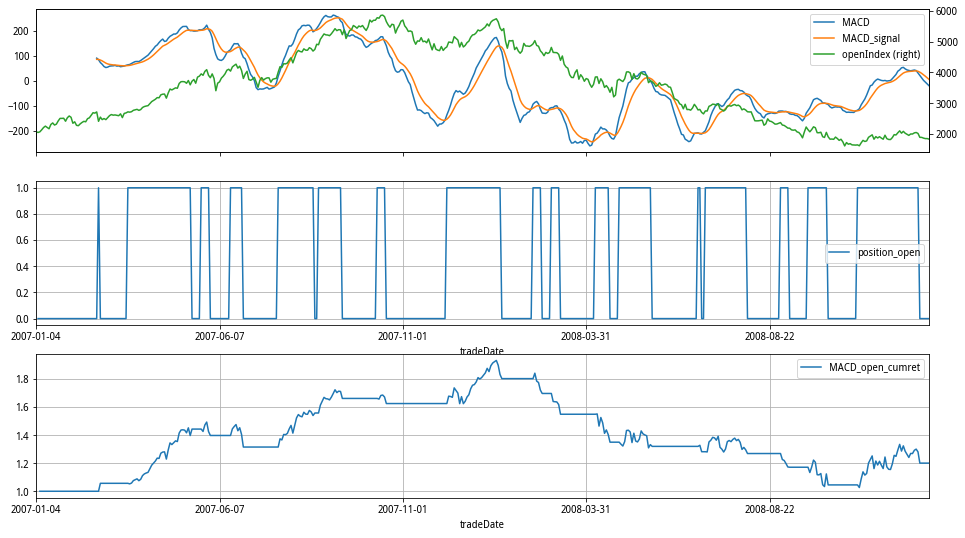

In [111]:
fig, axes = plt.subplots(3,1)
MACD_ret_df.loc[:'2009',['MACD','MACD_signal']].plot(ax=axes[0], grid=True)
MACD_ret_df.loc[:'2009',['openIndex']].plot(secondary_y=True,ax=axes[0])
MACD_ret_df.loc[:'2009',['position_open']].plot(ax=axes[1], grid=True)
MACD_ret_df.loc[:'2009',['MACD_open_cumret']].plot(ax=axes[2], grid=True)

## Cross-sectional test

In [112]:
stk_df

,secID,tradeDate,preClosePrice,closePrice,openPrice,highestPrice,lowestPrice,negMarketValue,turnoverValue,turnoverRate,EMA,open_ret,close_ret,signal
109,000001.XSHE,2007-06-20,824.193,987.007,1044.285,1053.778,970.235,4.835036e+10,4.182345e+09,0.0840,NaN,NaN,0.197544,0
110,000001.XSHE,2007-06-21,987.007,1085.740,1026.564,1085.740,988.906,5.318694e+10,2.285485e+09,0.0440,NaN,-0.016970,0.100033,0
111,000001.XSHE,2007-06-22,1085.740,1120.233,1126.562,1132.891,1069.601,5.487665e+10,2.761567e+09,0.0510,NaN,0.097410,0.031769,0
112,000001.XSHE,2007-06-25,1120.233,1113.904,1139.536,1157.574,1087.005,5.456661e+10,2.324186e+09,0.0426,NaN,0.011516,-0.005650,0
114,000001.XSHE,2007-06-27,1113.904,1019.602,1002.513,1069.284,1002.513,4.994705e+10,2.446556e+09,0.0489,NaN,-0.120245,-0.084659,0
115,000001.XSHE,2007-06-28,1019.602,953.780,996.817,1024.348,950.299,4.672266e+10,1.617434e+09,0.0336,NaN,-0.005682,-0.064557,0
116,000001.XSHE,2007-06-29,953.780,870.870,943.021,948.717,861.377,4.266117e+10,1.410758e+09,0.0316,NaN,-0.053968,-0.086928,0
117,000001.XSHE,2007-07-02,870.870,867.073,848.402,881.629,840.807,4.247515e+10,8.756147e+08,0.0209,NaN,-0.100336,-0.004360,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11245239,689009.XSHG,2023-03-08,33.370,34.080,33.400,34.200,33.400,1.743874e+10,1.229896e+08,0.0071,33.677879,-0.017647,0.021277,1


In [113]:
stk_df.drop('EMA',axis=1,inplace=True)

In [114]:
stk_df['MACD'] = stk_df.groupby('secID')['closePrice'].apply(lambda x: ta.MACD(x)[0])
stk_df['MACD_signal'] = stk_df.groupby('secID')['closePrice'].apply(lambda x: ta.MACD(x)[1])

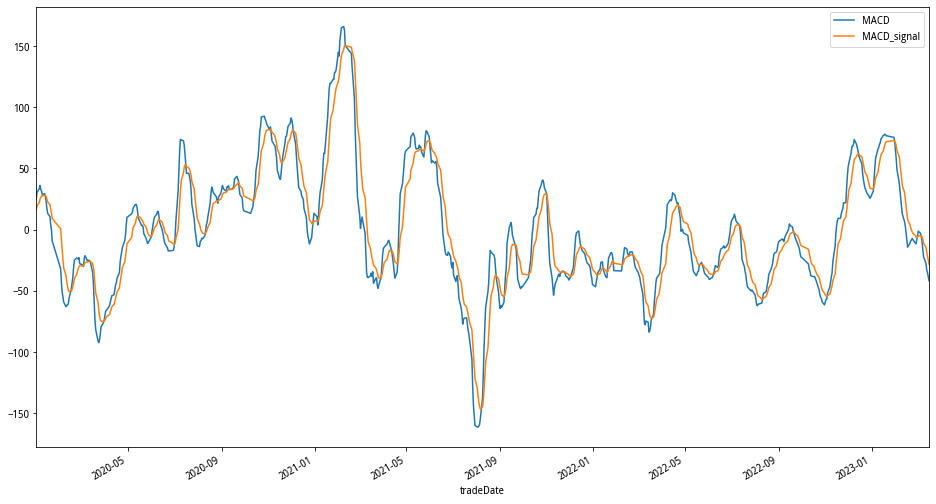

In [115]:
stk_df.loc[stk_df['secID']=='000001.XSHE',['tradeDate','MACD','MACD_signal']].set_index('tradeDate').loc['2020':].plot()

In [116]:
stk_df['signal'] = 0
stk_df.loc[stk_df['MACD'] > stk_df['MACD_signal'], 'signal'] = 1

In [117]:
stk_df

,secID,tradeDate,preClosePrice,closePrice,openPrice,highestPrice,lowestPrice,negMarketValue,turnoverValue,turnoverRate,open_ret,close_ret,signal,MACD,MACD_signal
109,000001.XSHE,2007-06-20,824.193,987.007,1044.285,1053.778,970.235,4.835036e+10,4.182345e+09,0.0840,NaN,0.197544,0,NaN,NaN
110,000001.XSHE,2007-06-21,987.007,1085.740,1026.564,1085.740,988.906,5.318694e+10,2.285485e+09,0.0440,-0.016970,0.100033,0,NaN,NaN
111,000001.XSHE,2007-06-22,1085.740,1120.233,1126.562,1132.891,1069.601,5.487665e+10,2.761567e+09,0.0510,0.097410,0.031769,0,NaN,NaN
112,000001.XSHE,2007-06-25,1120.233,1113.904,1139.536,1157.574,1087.005,5.456661e+10,2.324186e+09,0.0426,0.011516,-0.005650,0,NaN,NaN
114,000001.XSHE,2007-06-27,1113.904,1019.602,1002.513,1069.284,1002.513,4.994705e+10,2.446556e+09,0.0489,-0.120245,-0.084659,0,NaN,NaN
115,000001.XSHE,2007-06-28,1019.602,953.780,996.817,1024.348,950.299,4.672266e+10,1.617434e+09,0.0336,-0.005682,-0.064557,0,NaN,NaN
116,000001.XSHE,2007-06-29,953.780,870.870,943.021,948.717,861.377,4.266117e+10,1.410758e+09,0.0316,-0.053968,-0.086928,0,NaN,NaN
117,000001.XSHE,2007-07-02,870.870,867.073,848.402,881.629,840.807,4.247515e+10,8.756147e+08,0.0209,-0.100336,-0.004360,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11245239,689009.XSHG,2023-03-08,33.370,34.080,33.400,34.200,33.400,1.743874e+10,1.229896e+08,0.0071,-0.017647,0.021277,0,0.147829,0.166803


In [118]:
%%time
rule_ret_df = stk_df.groupby('secID').apply(rule_return)

CPU times: user 42.8 s, sys: 1.02 s, total: 43.8 s
Wall time: 43.8 s


In [119]:
rule_ret_df.reset_index(inplace=True)

In [120]:
rule_ret_df.drop('level_1',axis=1,inplace=True)

In [121]:
rule_ret_df

,secID,tradeDate,position_open_ret_demean,open_cumret
0,000001.XSHE,2007-06-20,NaN,NaN
1,000001.XSHE,2007-06-21,NaN,NaN
2,000001.XSHE,2007-06-22,0.0,1.000000
3,000001.XSHE,2007-06-25,0.0,1.000000
4,000001.XSHE,2007-06-27,-0.0,1.000000
5,000001.XSHE,2007-06-28,-0.0,1.000000
6,000001.XSHE,2007-06-29,-0.0,1.000000
7,000001.XSHE,2007-07-02,-0.0,1.000000
...,...,...,...,...
10347861,689009.XSHG,2023-03-08,-0.0,0.774221


### Cross-sectional test of cumulative return

In [122]:
rule_cumret_by_crs = rule_ret_df.groupby('secID')['open_cumret'].last()

In [123]:
rule_cumret_by_crs

secID
000001.XSHE     1.182782
000002.XSHE     3.124518
000004.XSHE     5.161798
000005.XSHE     2.925598
000006.XSHE    10.531976
000007.XSHE     2.548448
000008.XSHE     3.194808
000009.XSHE    20.114053
                 ...    
688789.XSHG     0.926694
688793.XSHG     0.482570
688798.XSHG     0.687393
688799.XSHG     0.720548
688800.XSHG     0.470195
688819.XSHG     0.988404
688981.XSHG     0.721885
689009.XSHG     0.774221
Name: open_cumret, Length: 5073, dtype: float64

In [124]:
rule_cumret_by_crs.describe()

count    5071.000000
mean        2.129274
std         3.040458
min         0.010465
25%         0.786319
50%         1.189037
75%         2.189940
max        65.939243
Name: open_cumret, dtype: float64

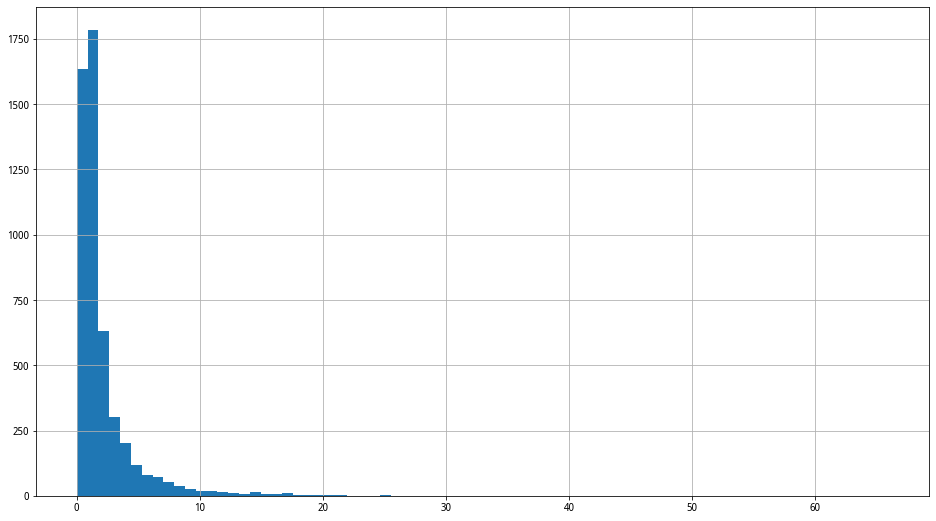

In [125]:
rule_cumret_by_crs.hist(bins=75)

In [126]:
rule_cumret_by_crs.dropna(inplace=True)
y = rule_cumret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y-const, const).fit().get_robustcov_results(cov_type='HC0')
mean_values = reg.params[0]
t_values = reg.tvalues[0]
pd.DataFrame([mean_values,t_values],index=['ret_mean','t_values'],columns=['rule_cumret'])

,rule_cumret
ret_mean,1.129274
t_values,26.451474


In [127]:
rule_cumret_by_crs.dropna(inplace=True)
y = rule_cumret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y, const).fit()
print(reg.t_test('const = 1'))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             2.1293      0.043     26.449      0.000       2.046       2.213


平均年化收益：

In [128]:
2.1293**(1/(2022-2007+1))-1

0.04837052777619055

### Cross-sectional test of mean daily return

In [129]:
# time-series mean of daily return
rule_tsmean_ret_by_crs = rule_ret_df.groupby('secID')['position_open_ret_demean'].mean()
rule_tsmean_ret_by_crs

secID
000001.XSHE   -0.000036
000002.XSHE    0.000128
000004.XSHE    0.000701
000005.XSHE    0.000507
000006.XSHE    0.000467
000007.XSHE    0.000152
000008.XSHE    0.000233
000009.XSHE    0.000710
                 ...   
688789.XSHG   -0.000410
688793.XSHG   -0.000465
688798.XSHG   -0.000095
688799.XSHG   -0.000161
688800.XSHG   -0.002201
688819.XSHG    0.000709
688981.XSHG   -0.000069
689009.XSHG   -0.000509
Name: position_open_ret_demean, Length: 5073, dtype: float64

In [130]:
rule_tsmean_ret_by_crs.dropna(inplace=True)
y = rule_tsmean_ret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HC0')
mean_values = reg.params[0]
t_values = reg.tvalues[0]

In [131]:
pd.DataFrame([mean_values,t_values],index=['ret_mean','t_values'],columns=['rule_daily_ret'])

,rule_daily_ret
ret_mean,-0.000004
t_values,-0.394879


## Time series test. Bootstrapping: White's Reality Check

- 原始index return去掉均值的目的：过滤掉牛市或者熊市时，随机策略的正或负的收益的偏误
- position return 去掉均值的目的：bootstrap 的原假设是：策略期望收益是0。以此生成抽样分布。

In [132]:
rule_ret_series = MACD_ret_df['position_open_ret_demean'].dropna() # position_open_ret_demean: (raw return demeaned)*position
rule_ret_series_for_bootstrap = rule_ret_series - rule_ret_series.mean() # demean here: H0: the average of the rule's return is zero
n_sample = rule_ret_series.shape[0]
n_boostrap = 1000

In [133]:
n_sample

3938

In [134]:
rule_ret_series.mean()

0.00011739401864302237

In [135]:
rule_ret_mean_distr = []
for i in range(n_boostrap):
    rule_ret_mean_distr.append(np.random.choice(rule_ret_series_for_bootstrap, n_sample).mean())

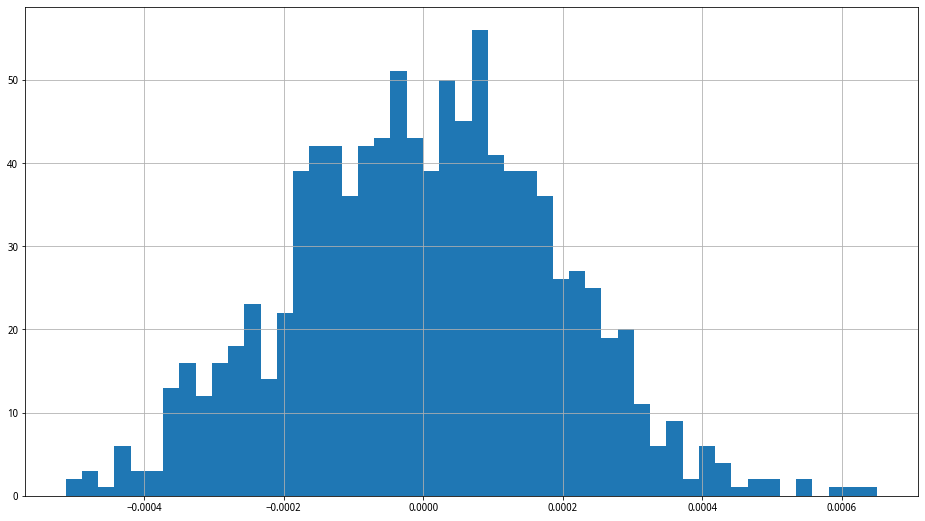

In [136]:
rule_ret_mean_distr = pd.Series(rule_ret_mean_distr)
rule_ret_mean_distr.hist(bins=50)

In [137]:
(rule_ret_mean_distr > rule_ret_series.mean()).sum() / n_boostrap

0.277

In [138]:
np.mean(rule_ret_series)

0.00011739401864302237

In [139]:
def white_reality_test(rule_ret, n_boostrap=1000):
    n_sample = len(rule_ret)
    if n_sample < 100:
        return None
    else:
        mean_rule_ret = np.mean(rule_ret)
        rule_ret_for_bootstrap = rule_ret - mean_rule_ret
        rule_ret_mean_distr = []
        for i in range(n_boostrap):
            rule_ret_mean_distr.append(np.random.choice(rule_ret_for_bootstrap, n_sample).mean())
        rule_ret_mean_distr = pd.Series(rule_ret_mean_distr)
        pvalue = (rule_ret_mean_distr > mean_rule_ret).sum() / n_boostrap
        return pvalue

In [140]:
# The p value of the rule's return series
white_reality_test(rule_ret_series)

0.253

#### Test another stock

In [141]:
one_stk_id = np.random.choice(rule_ret_df['secID'].unique(),1)[0]

In [142]:
rule_ret_series = rule_ret_df.loc[rule_ret_df['secID'] == one_stk_id,'position_open_ret_demean']

In [143]:
rule_ret_series.dropna(inplace=True)

In [144]:
white_reality_test(rule_ret_series)

0.244

#### Test 300 stocks

In [145]:
stk_id_300 = np.random.choice(rule_ret_df['secID'].unique(),300,replace=False)

In [146]:
temp = rule_ret_df.loc[rule_ret_df['secID'].isin(stk_id_300)].copy()

In [147]:
temp.dropna(inplace=True)

In [148]:
temp

,secID,tradeDate,position_open_ret_demean,open_cumret
12737,000006.XSHE,2007-01-08,0.000000,1.000000
12738,000006.XSHE,2007-01-09,0.000000,1.000000
12739,000006.XSHE,2007-01-10,0.000000,1.000000
12740,000006.XSHE,2007-01-11,0.000000,1.000000
12741,000006.XSHE,2007-01-12,-0.000000,1.000000
12742,000006.XSHE,2007-01-15,-0.000000,1.000000
12743,000006.XSHE,2007-01-16,0.000000,1.000000
12744,000006.XSHE,2007-01-17,0.000000,1.000000
...,...,...,...,...
10345707,688799.XSHG,2023-03-08,-0.022050,0.733600


In [149]:
%%time
stk_white_p = temp.groupby('secID')['position_open_ret_demean'].apply(white_reality_test)

CPU times: user 31.9 s, sys: 0 ns, total: 31.9 s
Wall time: 31.9 s


In [150]:
stk_white_p

secID
000006.XSHE    0.087
000069.XSHE    0.306
000426.XSHE    0.611
000526.XSHE    0.501
000550.XSHE    0.793
000553.XSHE    0.687
000573.XSHE    0.295
000601.XSHE    0.244
               ...  
688598.XSHG    0.430
688618.XSHG    0.313
688621.XSHG    0.271
688625.XSHG    0.761
688663.XSHG    0.084
688698.XSHG    0.225
688700.XSHG    0.730
688799.XSHG    0.571
Name: position_open_ret_demean, Length: 300, dtype: float64

In [151]:
stk_white_p.describe()

count    298.000000
mean       0.498248
std        0.250244
min        0.035000
25%        0.286250
50%        0.478500
75%        0.702500
max        0.994000
Name: position_open_ret_demean, dtype: float64

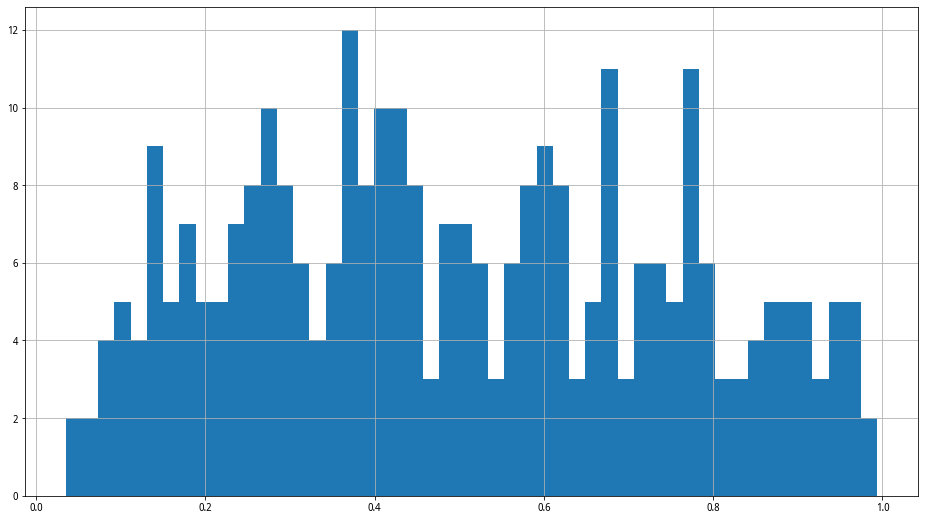

In [152]:
stk_white_p.hist(bins=50)

In [153]:
stk_white_p.loc[stk_white_p < 0.10]

secID
000006.XSHE    0.087
002493.XSHE    0.090
002500.XSHE    0.035
600770.XSHG    0.055
600827.XSHG    0.052
600843.XSHG    0.099
688056.XSHG    0.082
688339.XSHG    0.071
688663.XSHG    0.084
Name: position_open_ret_demean, dtype: float64

In [154]:
good_MACD_stks = stk_white_p.loc[stk_white_p < 0.10].index

In [155]:
rule_ret_df.loc[rule_ret_df['secID']=='301296.XSHE','open_cumret']

5945177         NaN
5945178         NaN
5945179    1.000000
5945180    1.000000
5945181    1.000000
5945182    1.000000
5945183    1.000000
5945184    1.000000
             ...   
5945298    1.278667
5945299    1.278667
5945300    1.278667
5945301    1.278667
5945302    1.278667
5945303    1.278667
5945304    1.278667
5945305    1.278667
Name: open_cumret, Length: 129, dtype: float64

In [156]:
rule_ret_df.loc[rule_ret_df['secID'].isin(good_MACD_stks[0:5])].set_index('tradeDate',inplace=True)

In [157]:
temp2 = rule_ret_df.loc[rule_ret_df['secID'].isin(good_MACD_stks)].copy()

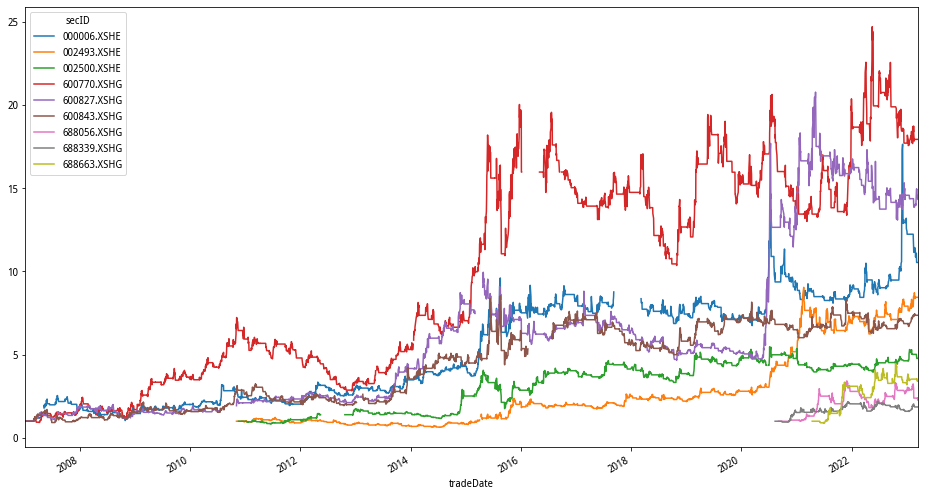

In [158]:
temp2.pivot(index='tradeDate',columns='secID',values='open_cumret').plot()

# White's Reality Check for multiple strategies

In [159]:
def rule_return_open(df, demean=True):
    """
    df should contain these columns:
        signal: the signal generated by the rule
        close_ret: return calculated by close price
        open_ret: return calculated by open price
    close_ret_demean is demeaned return of close_ret, i.e. close_ret - close_ret.mean.
    open_ret_demean is similarly defined. The use of demeaned return series is to adjust the
    bias created by bullish or bearish markets.
    """
    df['position_open'] = df['signal'].shift()
    df['position_open_ret'] = df['position_open'].shift() * df['open_ret']
    df['position_open_ret_demean'] = df['position_open'].shift() * df['open_ret_demean']
    if demean==True:
        return df['position_open_ret_demean']
    else:
        return df['position_open_ret']

In [160]:
cols = ['tradeDate','openIndex','closeIndex','open_ret','close_ret','open_ret_demean','close_ret_demean']
ta_rules_df = hs300_df[cols].copy()

In [161]:
# MA
ma_params = [30, 20, 10]
for ma_param in ma_params:
    ta_rules_df[f'MA{ma_param}'] = ta.SMA(ta_rules_df['closeIndex'], ma_param)
    ta_rules_df['signal'] = np.nan
    ta_rules_df.loc[ta_rules_df['closeIndex'] > ta_rules_df[f'MA{ma_param}'], 'signal'] = 1
    ta_rules_df.loc[ta_rules_df['closeIndex'] < ta_rules_df[f'MA{ma_param}'], 'signal'] = 0
    ta_rules_df[f'ret_MA{ma_param}'] = rule_return_open(ta_rules_df)
    
ta_rules_df = ta_rules_df[cols+[f'ret_MA{ma_param}' for ma_param in ma_params]].copy()

In [162]:
ta_rules_df

,tradeDate,openIndex,closeIndex,open_ret,close_ret,open_ret_demean,close_ret_demean,ret_MA30,ret_MA20,ret_MA10
0,2007-01-04,2073.2500,2067.0900,NaN,0.012758,NaN,0.012448,NaN,NaN,NaN
1,2007-01-05,2051.1500,2072.8800,-0.010660,0.002801,-0.010990,0.002491,NaN,NaN,NaN
2,2007-01-08,2072.0000,2131.5600,0.010165,0.028308,0.009834,0.027998,NaN,NaN,NaN
3,2007-01-09,2137.4900,2200.0900,0.031607,0.032150,0.031276,0.031840,NaN,NaN,NaN
4,2007-01-10,2210.7600,2255.9700,0.034279,0.025399,0.033948,0.025089,NaN,NaN,NaN
5,2007-01-11,2257.0100,2231.6300,0.020920,-0.010789,0.020590,-0.011099,NaN,NaN,NaN
6,2007-01-12,2215.8600,2173.7500,-0.018232,-0.025936,-0.018563,-0.026246,NaN,NaN,NaN
7,2007-01-15,2170.9400,2287.3400,-0.020272,0.052255,-0.020603,0.051945,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3932,2023-03-08,4030.7387,4034.1077,-0.017765,-0.003642,-0.018096,-0.003952,-0.0,-0.018096,-0.018096


In [163]:
cols = ta_rules_df.columns.tolist()

In [164]:
#EMA
ema_params = [30, 20, 10]
for ema_param in ema_params:
    ta_rules_df[f'EMA{ema_param}'] = ta.EMA(ta_rules_df['closeIndex'], ema_param)
    ta_rules_df['signal'] = np.nan
    ta_rules_df.loc[ta_rules_df['closeIndex'] > ta_rules_df[f'EMA{ema_param}'], 'signal'] = 1
    ta_rules_df.loc[ta_rules_df['closeIndex'] < ta_rules_df[f'EMA{ema_param}'], 'signal'] = 0
    ta_rules_df[f'ret_EMA{ema_param}'] = rule_return_open(ta_rules_df)
    
ta_rules_df = ta_rules_df[cols+[f'ret_EMA{ema_param}' for ema_param in ema_params]].copy()

In [165]:
ta_rules_df

,tradeDate,openIndex,closeIndex,open_ret,close_ret,open_ret_demean,close_ret_demean,ret_MA30,ret_MA20,ret_MA10,ret_EMA30,ret_EMA20,ret_EMA10
0,2007-01-04,2073.2500,2067.0900,NaN,0.012758,NaN,0.012448,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-01-05,2051.1500,2072.8800,-0.010660,0.002801,-0.010990,0.002491,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-01-08,2072.0000,2131.5600,0.010165,0.028308,0.009834,0.027998,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-01-09,2137.4900,2200.0900,0.031607,0.032150,0.031276,0.031840,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-01-10,2210.7600,2255.9700,0.034279,0.025399,0.033948,0.025089,NaN,NaN,NaN,NaN,NaN,NaN
5,2007-01-11,2257.0100,2231.6300,0.020920,-0.010789,0.020590,-0.011099,NaN,NaN,NaN,NaN,NaN,NaN
6,2007-01-12,2215.8600,2173.7500,-0.018232,-0.025936,-0.018563,-0.026246,NaN,NaN,NaN,NaN,NaN,NaN
7,2007-01-15,2170.9400,2287.3400,-0.020272,0.052255,-0.020603,0.051945,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3932,2023-03-08,4030.7387,4034.1077,-0.017765,-0.003642,-0.018096,-0.003952,-0.0,-0.018096,-0.018096,-0.018096,-0.018096,-0.018096


In [166]:
cols = ta_rules_df.columns.tolist()

In [167]:
# MACD
macd_models = {'MACD1': {'fastperiod':12, 'slowperiod':26, 'signalperiod':9},
               'MACD2': {'fastperiod':10, 'slowperiod':20, 'signalperiod':5}}
for macd, param in macd_models.items():
    ta_rules_df[macd], ta_rules_df[f'{macd}_signal'], _ = ta.MACD(ta_rules_df['closeIndex'], fastperiod=param['fastperiod'], slowperiod=param['slowperiod'], signalperiod=param['signalperiod'])
    ta_rules_df['signal'] = 0
    ta_rules_df.loc[ta_rules_df[macd] > ta_rules_df[f'{macd}_signal'], 'signal'] = 1
    ta_rules_df[f'ret_{macd}'] = rule_return_open(ta_rules_df)

In [168]:
ta_rules_df.dropna(inplace=True)
ta_rules_df.reset_index(inplace=True,drop=True)

In [169]:
ta_rules_df

,tradeDate,openIndex,closeIndex,open_ret,close_ret,open_ret_demean,close_ret_demean,ret_MA30,ret_MA20,ret_MA10,...,MACD1,MACD1_signal,signal,position_open,position_open_ret,position_open_ret_demean,ret_MACD1,MACD2,MACD2_signal,ret_MACD2
0,2007-02-27,2717.8100,2457.4900,0.014385,-0.092400,0.014054,-0.092710,0.014054,0.014054,0.014054,...,90.911597,86.028313,0,1.0,0.014385,0.014054,0.000000,71.690413,73.792501,0.014054
1,2007-02-28,2413.4200,2544.5700,-0.111998,0.035435,-0.112329,0.035125,-0.112329,-0.112329,-0.112329,...,84.683369,85.759325,0,0.0,-0.111998,-0.112329,-0.000000,65.064530,70.883178,-0.112329
2,2007-03-01,2550.2600,2473.5400,0.056700,-0.027914,0.056369,-0.028224,0.056369,0.000000,0.000000,...,73.172441,83.241948,0,0.0,0.000000,0.000000,0.056369,52.883214,64.883190,0.000000
3,2007-03-02,2468.6700,2508.7300,-0.031993,0.014227,-0.032324,0.013917,-0.032324,-0.032324,-0.000000,...,66.127212,79.819001,0,0.0,-0.000000,-0.000000,-0.000000,45.996903,58.587761,-0.000000
4,2007-03-05,2503.8200,2475.6100,0.014238,-0.013202,0.013908,-0.013512,0.013908,0.000000,0.000000,...,57.211809,75.297562,0,0.0,0.000000,0.000000,0.000000,37.235228,51.470250,0.000000
5,2007-03-06,2467.7400,2520.2900,-0.014410,0.018048,-0.014741,0.017738,-0.014741,-0.014741,-0.000000,...,53.139036,70.865857,0,0.0,-0.000000,-0.000000,-0.000000,33.972945,45.637815,-0.000000
6,2007-03-07,2532.9800,2589.4400,0.026437,0.027437,0.026106,0.027127,0.026106,0.026106,0.000000,...,54.858783,67.664442,0,0.0,0.000000,0.000000,0.000000,36.956746,42.744125,0.000000
7,2007-03-08,2597.7200,2627.6300,0.025559,0.014748,0.025228,0.014438,0.025228,0.025228,0.000000,...,58.627488,65.857051,0,0.0,0.000000,0.000000,0.000000,41.832083,42.440111,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3899,2023-03-08,4030.7387,4034.1077,-0.017765,-0.003642,-0.018096,-0.003952,-0.000000,-0.018096,-0.018096,...,0.261003,10.237303,0,0.0,-0.017765,-0.018096,-0.000000,-6.261209,-0.960044,-0.018096


In [170]:
multi_rule_cols = ta_rules_df.columns[ta_rules_df.columns.str.startswith('ret')]

multi_rule_ret_df = ta_rules_df[multi_rule_cols].copy()

multi_rule_ret_df

,ret_MA30,ret_MA20,ret_MA10,ret_EMA30,ret_EMA20,ret_EMA10,ret_MACD1,ret_MACD2
0,0.014054,0.014054,0.014054,0.014054,0.014054,0.014054,0.000000,0.014054
1,-0.112329,-0.112329,-0.112329,-0.112329,-0.112329,-0.112329,-0.000000,-0.112329
2,0.056369,0.000000,0.000000,0.056369,0.000000,0.000000,0.056369,0.000000
3,-0.032324,-0.032324,-0.000000,-0.032324,-0.032324,-0.032324,-0.000000,-0.000000
4,0.013908,0.000000,0.000000,0.013908,0.000000,0.000000,0.000000,0.000000
5,-0.014741,-0.014741,-0.000000,-0.014741,-0.014741,-0.000000,-0.000000,-0.000000
6,0.026106,0.026106,0.000000,0.026106,0.000000,0.000000,0.000000,0.000000
7,0.025228,0.025228,0.000000,0.025228,0.025228,0.025228,0.000000,0.000000
...,...,...,...,...,...,...,...,...
3899,-0.000000,-0.018096,-0.018096,-0.018096,-0.018096,-0.018096,-0.000000,-0.018096


In [171]:
def multi_white_reality_test(target_rule, multi_rule_ret_df, n_bootstrap=500):
    """
    target_rule: the name of the rule under consideration. target_rule should be one column of multi_rule_ret_df.
    multi_rule_ret_df: the df of multiple rule returns.
    """
    n_sample = multi_rule_ret_df.shape[0]
    if n_sample < 100:
        return None
    else:   
        max_bs_distr = np.full(shape=n_bootstrap, fill_value=np.nan)
        multi_rule_ret_df_mean = multi_rule_ret_df - multi_rule_ret_df.mean()
        for i in tqdm(range(n_bootstrap)):
            idx = np.random.choice(multi_rule_ret_df.index, n_sample)
            max_bs_distr[i] = multi_rule_ret_df_mean.loc[idx].mean().max()
        pvalue = (max_bs_distr > multi_rule_ret_df[target_rule].mean()).sum() / n_bootstrap
        return pvalue, max_bs_distr

In [172]:
p_MACD1, max_bs_distr_MACD1 = multi_white_reality_test(target_rule='ret_MA30', multi_rule_ret_df=multi_rule_ret_df)

100%|██████████| 500/500 [00:00<00:00, 836.15it/s]


In [173]:
p_MACD1

0.486

Compare this with the WRC when there is only one 